In [2]:
# -----------------------------------------------------------------------------
# this runs the Cape Cod site flow case for the Harvey and Garabedian bacterial
# injection experiment from Maxwell, et al, 2007.
# -----------------------------------------------------------------------------

import os, sys
from set_demo_defaults import *

import matplotlib.pyplot as plt
from parflow import Run
from parflow.tools.fs import cp, chdir, mkdir, get_absolute_path, rm
from parflow.tools.io import read_pfb, write_pfb, ParflowBinaryReader
from parflow.tools.compare import pf_test_file
from parflow.tools.hydrology import compute_hydraulic_head
from plots import plot_domain_corr_rnd
import numpy as np

run_name = "harvey_flow.1"
dir_name = f"./test_output/harvey_flow"
mkdir(dir_name)

def correlated_random_field(alpha_vG, Sigma_input):
    #hflow = Run(run_name, __file__)
    hflow = Run(run_name)
    
    # -----------------------------------------------------------------------------
    # File input version number
    # -----------------------------------------------------------------------------
    
    hflow.FileVersion = 4
    
    # -----------------------------------------------------------------------------
    # Process Topology
    # -----------------------------------------------------------------------------
    
    hflow.Process.Topology.P = 1
    hflow.Process.Topology.Q = 1
    hflow.Process.Topology.R = 1
    
    # -----------------------------------------------------------------------------
    # Computational Grid
    # -----------------------------------------------------------------------------
    hflow.ComputationalGrid.Lower.X = 0.0
    hflow.ComputationalGrid.Lower.Y = 0.0
    hflow.ComputationalGrid.Lower.Z = 0.0
    
    hflow.ComputationalGrid.DX = 0.34
    hflow.ComputationalGrid.DY = 1.0
    hflow.ComputationalGrid.DZ = 0.038
    
    hflow.ComputationalGrid.NX = 50
    hflow.ComputationalGrid.NY = 1
    hflow.ComputationalGrid.NZ = 100
    
    # -----------------------------------------------------------------------------
    # The Names of the GeomInputs
    # -----------------------------------------------------------------------------
    
    hflow.GeomInput.Names = "domain_input upper_aquifer_input"
    
    # -----------------------------------------------------------------------------
    # Domain Geometry Input
    # -----------------------------------------------------------------------------
    
    hflow.GeomInput.domain_input.InputType = "Box"
    hflow.GeomInput.domain_input.GeomName = "domain"
    
    # -----------------------------------------------------------------------------
    # Domain Geometry
    # -----------------------------------------------------------------------------
    hflow.Geom.domain.Lower.X = 0.0
    hflow.Geom.domain.Lower.Y = 0.0
    hflow.Geom.domain.Lower.Z = 0.0
    
    hflow.Geom.domain.Upper.X = 17.0
    hflow.Geom.domain.Upper.Y = 1.0
    hflow.Geom.domain.Upper.Z = 3.8
    
    hflow.Geom.domain.Patches = "left right front back bottom top"
    
    # -----------------------------------------------------------------------------
    # Upper Aquifer Geometry Input
    # -----------------------------------------------------------------------------
    
    hflow.GeomInput.upper_aquifer_input.InputType = "Box"
    hflow.GeomInput.upper_aquifer_input.GeomName = "upper_aquifer"
    
    # -----------------------------------------------------------------------------
    # Upper Aquifer Geometry
    # -----------------------------------------------------------------------------
    
    hflow.Geom.upper_aquifer.Lower.X = 0.0
    hflow.Geom.upper_aquifer.Lower.Y = 0.0
    hflow.Geom.upper_aquifer.Lower.Z = 0.0
    
    hflow.Geom.upper_aquifer.Upper.X = 17.0
    hflow.Geom.upper_aquifer.Upper.Y = 1.0
    hflow.Geom.upper_aquifer.Upper.Z = 3.8
    
    # -----------------------------------------------------------------------------
    # Perm
    # -----------------------------------------------------------------------------
    
    hflow.Geom.Perm.Names = "upper_aquifer"
    
    # we open a file, in this case from PEST to set upper and lower kg and sigma
    #cp("$./stats4.txt")
    chdir(".")
    
    file = open("stats4.txt", "r")
    lines = file.readlines()
    kgu = float(lines[0])
    varu = float(lines[1])
    
    ## we use the parallel turning bands formulation in ParFlow to simulate
    ## GRF for upper and lower aquifer
    
    hflow.Geom.upper_aquifer.Perm.Type = "TurnBands"
    hflow.Geom.upper_aquifer.Perm.LambdaX = 3.60
    hflow.Geom.upper_aquifer.Perm.LambdaY = 3.60
    hflow.Geom.upper_aquifer.Perm.LambdaZ = 0.19
    hflow.Geom.upper_aquifer.Perm.GeomMean = 112.00
    hflow.Geom.upper_aquifer.Perm.Sigma = Sigma_input
    hflow.Geom.upper_aquifer.Perm.NumLines = 150
    hflow.Geom.upper_aquifer.Perm.RZeta = 5.0
    hflow.Geom.upper_aquifer.Perm.KMax = 100.0000001
    hflow.Geom.upper_aquifer.Perm.DelK = 0.2
    hflow.Geom.upper_aquifer.Perm.Seed = 33333
    hflow.Geom.upper_aquifer.Perm.LogNormal = "Log"
    hflow.Geom.upper_aquifer.Perm.StratType = "Bottom"
    
    # -----------------------------------------------------------------------------
    # uncomment the lines below to run parallel gaussian instead
    # of parallel turning bands
    
    # hflow.Geom.upper_aquifer.Perm.Type = "ParGauss"
    
    # hflow.Geom.upper_aquifer.Perm.Seed = 1
    # hflow.Geom.upper_aquifer.Perm.MaxNPts = 70.0
    # hflow.Geom.upper_aquifer.Perm.MaxCpts = 20
    
    
    # pfset lower aqu and upper aq stats to pest/read in values
    # -----------------------------------------------------------------------------
    
    hflow.Perm.TensorType = "TensorByGeom"
    
    hflow.Geom.Perm.TensorByGeom.Names = "domain"
    
    hflow.Geom.domain.Perm.TensorValX = 1.0
    hflow.Geom.domain.Perm.TensorValY = 1.0
    hflow.Geom.domain.Perm.TensorValZ = 1.0
    
    # -----------------------------------------------------------------------------
    # Specific Storage
    # -----------------------------------------------------------------------------
    # specific storage does not figure into the impes (fully sat) case but we still
    # need a key for it
    
    hflow.SpecificStorage.Type = "Constant"
    hflow.SpecificStorage.GeomNames = ""
    hflow.Geom.domain.SpecificStorage.Value = 1.0e-4
    
    # -----------------------------------------------------------------------------
    # Phases
    # -----------------------------------------------------------------------------
    
    hflow.Phase.Names = "water"
    
    hflow.Phase.water.Density.Type = "Constant"
    hflow.Phase.water.Density.Value = 1.0
    
    hflow.Phase.water.Viscosity.Type = "Constant"
    hflow.Phase.water.Viscosity.Value = 1.0
    
    # -----------------------------------------------------------------------------
    # Contaminants
    # -----------------------------------------------------------------------------
    
    hflow.Contaminants.Names = ""
    
    # -----------------------------------------------------------------------------
    # Gravity
    # -----------------------------------------------------------------------------
    
    hflow.Gravity = 1.0
    
    # -----------------------------------------------------------------------------
    # Setup timing info
    # -----------------------------------------------------------------------------
    
    hflow.TimingInfo.BaseUnit = 1.0
    hflow.TimingInfo.StartCount = -1
    hflow.TimingInfo.StartTime = 0.0
    hflow.TimingInfo.StopTime = 100.0
    hflow.TimingInfo.DumpInterval = -1
    
    # -----------------------------------------------------------------------------
    # Porosity
    # -----------------------------------------------------------------------------
    
    hflow.Geom.Porosity.GeomNames = "domain"
    hflow.Geom.domain.Porosity.Type = "Constant"
    hflow.Geom.domain.Porosity.Value = 0.390
    
    # -----------------------------------------------------------------------------
    # Domain
    # -----------------------------------------------------------------------------
    
    hflow.Domain.GeomName = "domain"
    
    # -----------------------------------------------------------------------------
    # Mobility
    # -----------------------------------------------------------------------------
    
    hflow.Phase.water.Mobility.Type = "Constant"
    hflow.Phase.water.Mobility.Value = 1.0
    
    # -----------------------------------------------------------------------------
    # Wells
    # -----------------------------------------------------------------------------
    
    hflow.Wells.Names = ""
    
    # -----------------------------------------------------------------------------
    # Time Cycles
    # -----------------------------------------------------------------------------
    
    hflow.Cycle.Names = "constant"
    hflow.Cycle.constant.Names = "alltime"
    hflow.Cycle.constant.alltime.Length = 1
    hflow.Cycle.constant.Repeat = -1
    
    # -----------------------------------------------------------------------------
    # Boundary Conditions: Pressure
    # -----------------------------------------------------------------------------
    
    hflow.BCPressure.PatchNames = "left right front back bottom top"

    hflow.Patch.top.BCPressure.Type          = 'FluxConst'
    hflow.Patch.top.BCPressure.Cycle         = 'constant'
    hflow.Patch.top.BCPressure.alltime.Value = -0.05

    hflow.Patch.bottom.BCPressure.Type = "FluxConst"
    hflow.Patch.bottom.BCPressure.Cycle = "constant"
    hflow.Patch.bottom.BCPressure.alltime.Value = 0.0
    
    hflow.Patch.front.BCPressure.Type = "FluxConst"
    hflow.Patch.front.BCPressure.Cycle = "constant"
    hflow.Patch.front.BCPressure.alltime.Value = 0.0
    
    hflow.Patch.back.BCPressure.Type = "FluxConst"
    hflow.Patch.back.BCPressure.Cycle = "constant"
    hflow.Patch.back.BCPressure.alltime.Value = 0.0
    
    hflow.Patch.right.BCPressure.Type = "FluxConst"
    hflow.Patch.right.BCPressure.Cycle = "constant"
    hflow.Patch.right.BCPressure.alltime.Value = 0.0
    
    hflow.Patch.left.BCPressure.Type = "FluxConst"
    hflow.Patch.left.BCPressure.Cycle = "constant"
    hflow.Patch.left.BCPressure.alltime.Value = 0.0
    
    # ---------------------------------------------------------
    # Topo slopes in x-direction
    # ---------------------------------------------------------
    # topo slopes do not figure into the impes (fully sat) case but we still
    # need keys for them
    
    hflow.TopoSlopesX.Type = "Constant"
    hflow.TopoSlopesX.GeomNames = ""
    hflow.TopoSlopesX.Geom.domain.Value = 0.0
    
    # ---------------------------------------------------------
    # Topo slopes in y-direction
    # ---------------------------------------------------------
    
    hflow.TopoSlopesY.Type = "Constant"
    hflow.TopoSlopesY.GeomNames = ""
    
    hflow.TopoSlopesY.Geom.domain.Value = 0.0
    
    # ---------------------------------------------------------
    # Mannings coefficient
    # ---------------------------------------------------------
    # mannings roughnesses do not figure into the impes (fully sat) case but we still
    # need a key for them
    
    hflow.Mannings.Type = "Constant"
    hflow.Mannings.GeomNames = ""
    hflow.Mannings.Geom.domain.Value = 0.0
    
    # -----------------------------------------------------------------------------
    # Phase sources:
    # -----------------------------------------------------------------------------
    
    hflow.PhaseSources.water.Type = "Constant"
    hflow.PhaseSources.water.GeomNames = "domain"
    hflow.PhaseSources.water.Geom.domain.Value = 0.0
    
    #-----------------------------------------------------------------------------
    # Exact solution specification for error calculations
    #-----------------------------------------------------------------------------
    hflow.KnownSolution = 'NoKnownSolution'
    
    #-----------------------------------------------------------------------------
    # Relative Permeability
    #-----------------------------------------------------------------------------
    hflow.Phase.RelPerm.Type        = 'VanGenuchten'
    hflow.Phase.RelPerm.GeomNames   = 'domain'
    
    hflow.Geom.domain.RelPerm.Alpha = alpha_vG
    hflow.Geom.domain.RelPerm.N     = 2.0
    
    #---------------------------------------------------------
    # Saturation
    #---------------------------------------------------------
    hflow.Phase.Saturation.Type        = 'VanGenuchten'
    hflow.Phase.Saturation.GeomNames   = 'domain'
    
    hflow.Geom.domain.Saturation.Alpha = alpha_vG
    hflow.Geom.domain.Saturation.N     = 2.0
    hflow.Geom.domain.Saturation.SRes  = 0.2
    hflow.Geom.domain.Saturation.SSat  = 1.0
    
    #-----------------------------------------------------------------------------
    # Time Cycles
    #-----------------------------------------------------------------------------
    hflow.Cycle.Names = 'constant'
    hflow.Cycle.constant.Names = 'alltime'
    hflow.Cycle.constant.alltime.Length = 1
    hflow.Cycle.constant.Repeat = -1
    
    # Writing output options for ParFlow
    write_pfb = True  #only PFB output for water balance example
    #  PFB  no SILO
    hflow.Solver.PrintSubsurf             = True
    hflow.Solver.PrintSubsurfData         = write_pfb
    hflow.Solver.PrintPressure            = write_pfb
    hflow.Solver.PrintSaturation          = write_pfb
    hflow.Solver.PrintCLM                 = write_pfb
    hflow.Solver.PrintMask                = write_pfb
    hflow.Solver.PrintSpecificStorage     = write_pfb
    hflow.Solver.PrintEvapTrans           = write_pfb
    hflow.Solver.PrintVelocities          = True 
    
    #-----------------------------------------------------------------------------
    # Setup Timing
    #-----------------------------------------------------------------------------
    hflow.TimingInfo.BaseUnit     = 1.0
    hflow.TimingInfo.StartCount   = 0
    hflow.TimingInfo.StartTime    = 0.0
    hflow.TimingInfo.StopTime     = 100.0
    hflow.TimingInfo.DumpInterval = 1.0
    hflow.TimeStep.Type           = 'Constant'
    hflow.TimeStep.Value          = 1.0
    
    
    #-----------------------------------------------------------------------------
    # Set solver parameters
    #-----------------------------------------------------------------------------
    hflow.Solver         = 'Richards'
    hflow.Solver.MaxIter = 9000
    
    hflow.Solver.Nonlinear.MaxIter           = 100
    hflow.Solver.Nonlinear.ResidualTol       = 1e-5
    hflow.Solver.Nonlinear.EtaChoice         = 'Walker1'
    hflow.Solver.Nonlinear.EtaValue          = 0.01
    hflow.Solver.Nonlinear.UseJacobian       = True
    hflow.Solver.Nonlinear.DerivativeEpsilon = 1e-12
    hflow.Solver.Nonlinear.StepTol           = 1e-30
    hflow.Solver.Nonlinear.Globalization     = 'LineSearch'
    hflow.Solver.Linear.KrylovDimension      = 100
    hflow.Solver.Linear.MaxRestarts          = 5
    hflow.Solver.Linear.Preconditioner       = 'PFMG'
    hflow.Solver.PrintSubsurf                = True
    hflow.Solver.Drop                        = 1E-20
    hflow.Solver.AbsTol                      = 1E-9
    
    #---------------------------------------------------
    # Initial conditions: water pressure
    #---------------------------------------------------
    hflow.ICPressure.Type                 = 'Constant'
    hflow.ICPressure.GeomNames            = 'domain'
    hflow.Geom.domain.ICPressure.Value    = -50.00
    hflow.Geom.domain.ICPressure.RefGeom  = 'domain'
    hflow.Geom.domain.ICPressure.RefPatch = 'top'
    #This next cell sets the directory where ParFlow is installed and initiates a ParFlow run based on the keys defined above. Don't worry if parts of this (or all of it) seems intimidating or confusing; it takes time and practice to get used to anything new!
    
    
    # -----------------------------------------------------------------------------
    # Run and Unload the ParFlow output files
    # -----------------------------------------------------------------------------
    hflow.Geom.upper_aquifer.Perm.Seed = 33335
    
    hflow.run(working_directory=dir_name)

### Alpha = 1.0 (With capillarity), Deviation = 1 * sigma


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.39, vmax: 0.39


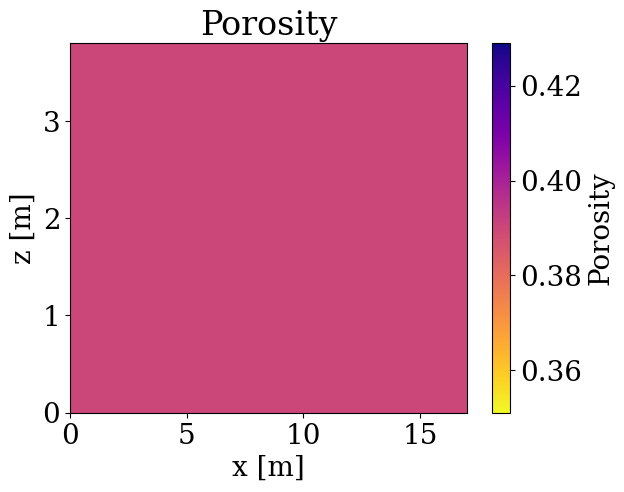

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 21.25133898761189, vmax: 403.7839899368552


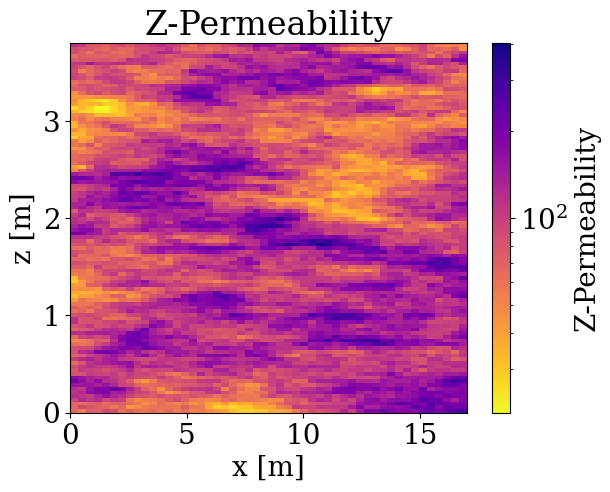

In [7]:
alpha_vG =1.0
time_array = [0, 1, 5, 10]
Sigma_input = 0.48989794
correlated_random_field(alpha_vG,Sigma_input)
plot_domain_corr_rnd(dir_name, "porosity", 0,Sigma_input)
plot_domain_corr_rnd(dir_name, "z-permeability", 0,Sigma_input)

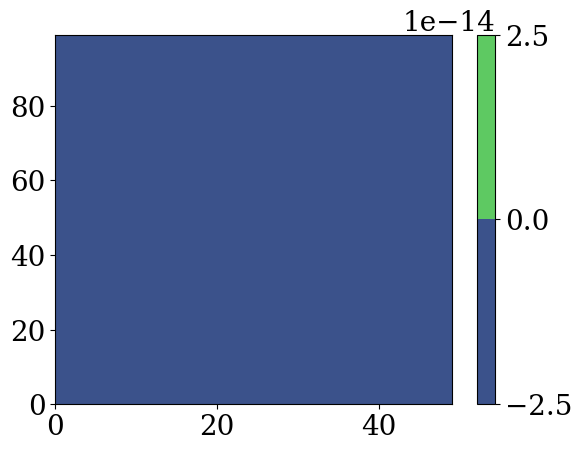

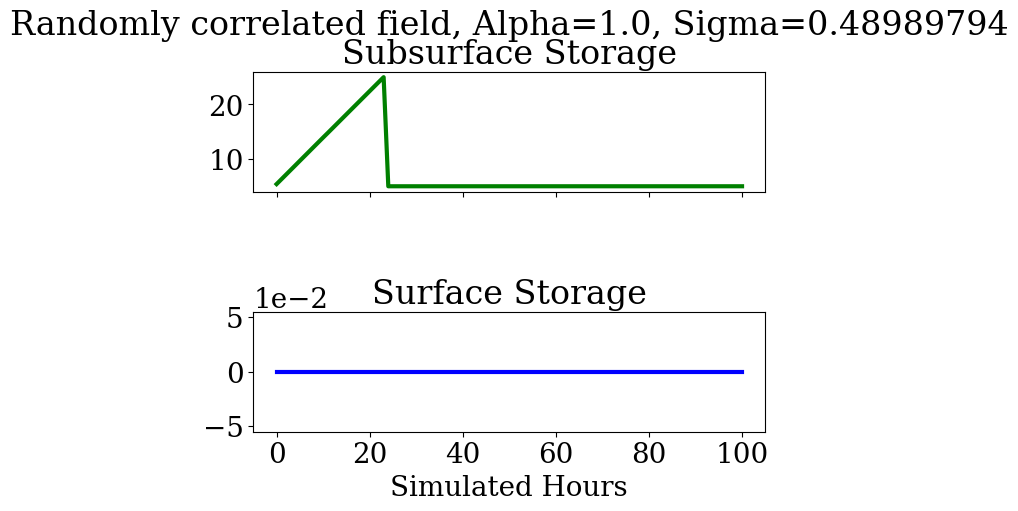

In [8]:
import parflow.tools.hydrology as hydro
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from parflow.tools.fs import get_absolute_path, cp, rm, mkdir, exists
import parflow as pf

def surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input):
    run = Run.from_definition(f'{dir_name}/{run_name}.pfidb')
    data = run.data_accessor
    nt = len(data.times)
    nx = data.shape[2]
    ny = data.shape[1]
    nz = data.shape[0]
    dx = data.dx
    dy = data.dy
    dz = data.dz
    
    #print(nt,nx,ny,nz,dx,dy,dz)
    
    porosity = data.computed_porosity 
    specific_storage = data.specific_storage
    
    mannings = run.Mannings.Geom.domain.Value
    
    ## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
    ## this fixes a windows issue
    run.TopoSlopesX.FileName = None
    run.TopoSlopesY.FileName = None
    
    #slopex = data.slope_x 
    #slopey = data.slope_y 
    mask = data.mask
    
    # formatting the mask so that values outside the domain are NA and inside the domain are 1
    nanmask=mask.copy()
    nanmask[nanmask == 0] = 'NaN'
    nanmask[nanmask > 0] = 1

    plt.contourf(data.mask[:,0,:])
    plt.colorbar()

    #Combining all outputs
    files = glob(f"{dir_name}/{run_name}.out.satur.*.pfb")
    saturation_arrays = pf.read_pfb_sequence(files)
    files = glob(f"{dir_name}/{run_name}.out.press.*.pfb")
    pressure_arrays = pf.read_pfb_sequence(files)

    subsurface_storage = np.zeros(nt+1)
    surface_storage = np.zeros(nt+1)
    data.time = 0

    
    for i, (pressure, saturation) in enumerate(zip(pressure_arrays, saturation_arrays)):
        subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask = None),axis=(0, 1, 2))
        # total surface storage for this time step is the summation of substorage surface across all x/y slices
        surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure, dx, dy, mask = None),axis=(0, 1))
        data.time = i
        #print(subsurface_storage[i, ...])
        #print(i,np.sum(porosity*saturation*dx*dy*dz[0]*(1+specific_storage)))

    np.savez(f'Rnd_corr_fields_surface_subsurface_storage_alphavG{alpha_vG}_sigma{Sigma_input}',subsurface_storage,surface_storage)  
    
    #plotting components of water balance
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle(f'Randomly correlated field, Alpha={alpha_vG}, Sigma={Sigma_input}')
    axs[0].plot(subsurface_storage[:-1], linewidth=3, color = "green")
    axs[0].set_title("Subsurface Storage")
    axs[1].plot(surface_storage[:-1], linewidth=3, color = "blue")
    axs[1].set_title("Surface Storage")
    plt.xlabel('Simulated Hours')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.85, 
                        wspace=0.7, 
                        hspace=1.0)
    axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.savefig(f'Rnd_corr_fields_surface_subsurface_storage_alphavG{alpha_vG}_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)

surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input)

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.0, vmax: -50.0


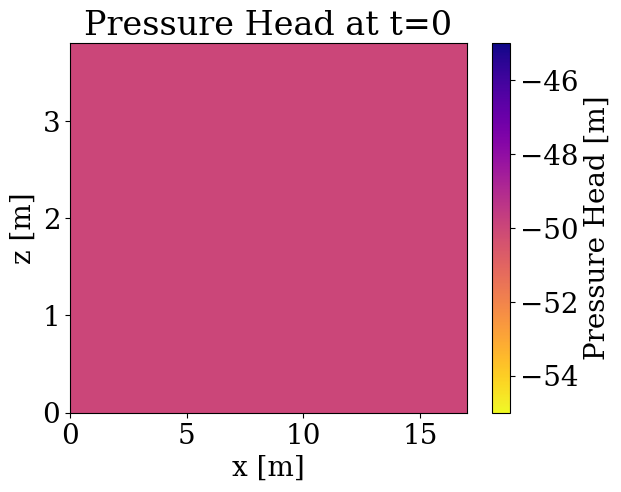

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.21599680095968013, vmax: 0.21599680095968013


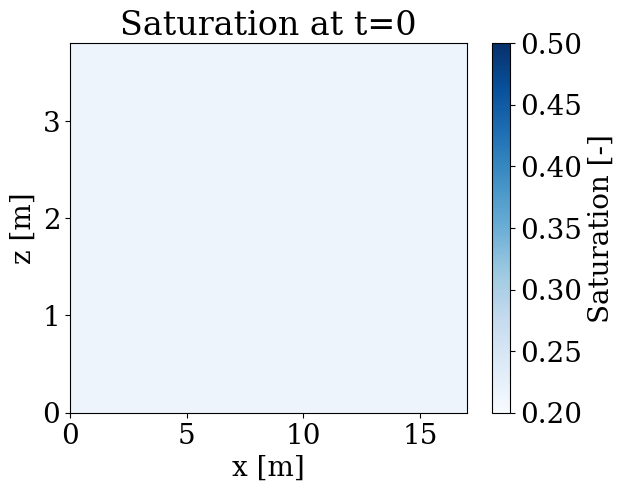

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.02703340934409, vmax: -4.717867360814665


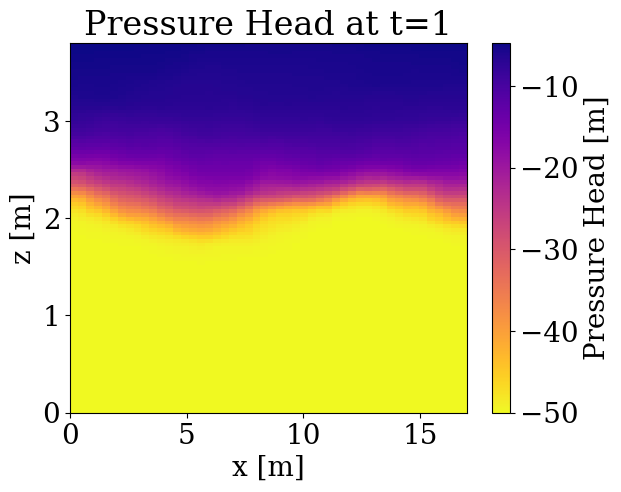

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.2159881601255333, vmax: 0.3658827629373744


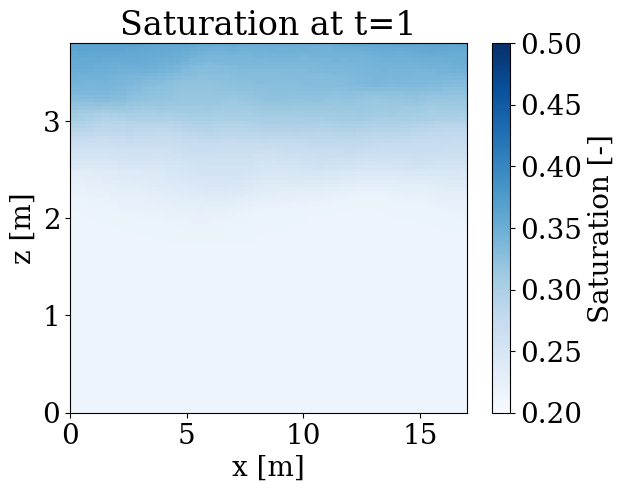

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -5.41047067807677, vmax: -3.5000033030164075


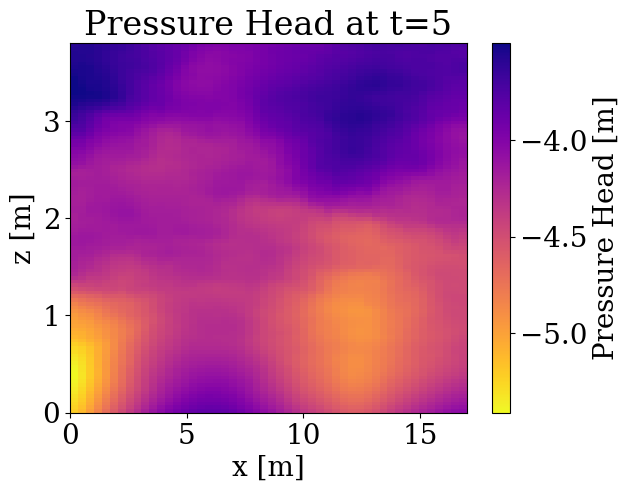

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.3453988168170695, vmax: 0.41977671056383653


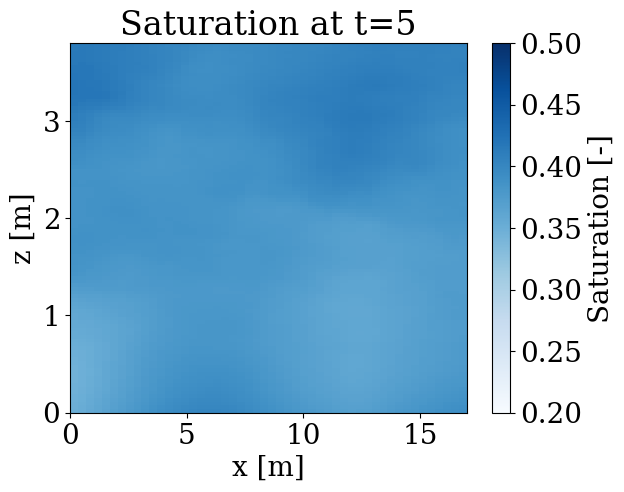

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -3.595860901893026, vmax: -0.6119069598020699


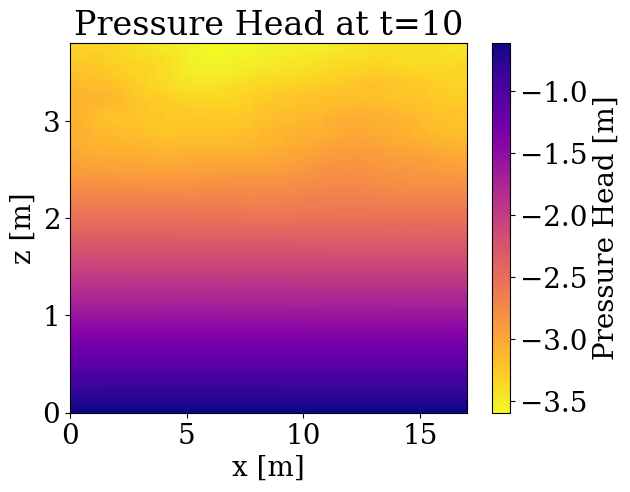

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.4143438699284013, vmax: 0.8823837148999201


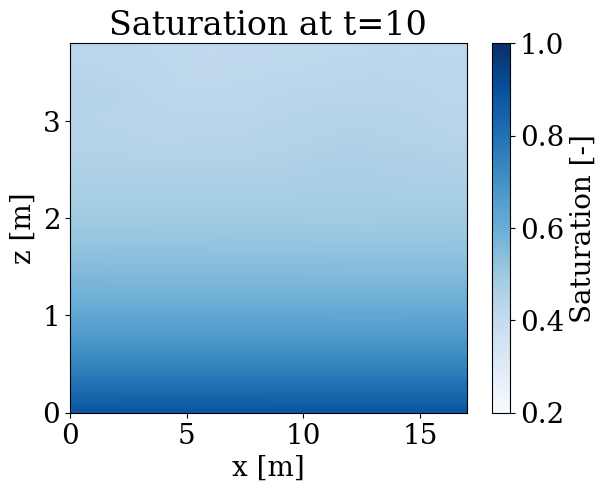

In [9]:
alpha_vG =1.0
for time in time_array:
    #Saturation and pressure at time t = 0 hours
    plot_domain_corr_rnd(dir_name, "press", time,alpha_vG,Sigma_input); 
    plot_domain_corr_rnd(dir_name, "satur", time,alpha_vG,Sigma_input)

### Alpha = 100.0 (Without capillarity), Deviation = 1 * sigma


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.0, vmax: -50.0


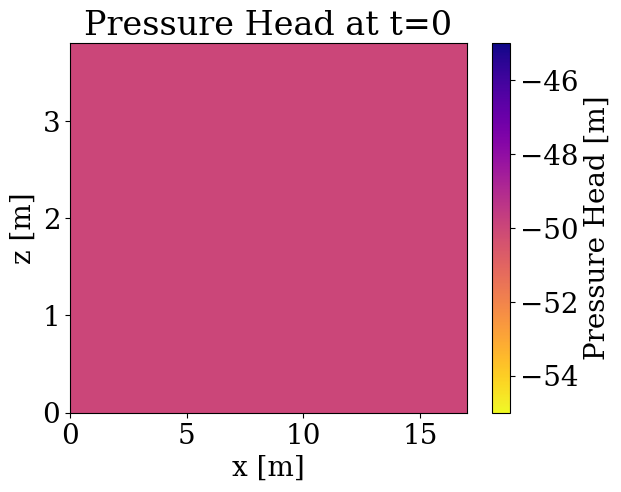

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.2001599999968, vmax: 0.2001599999968


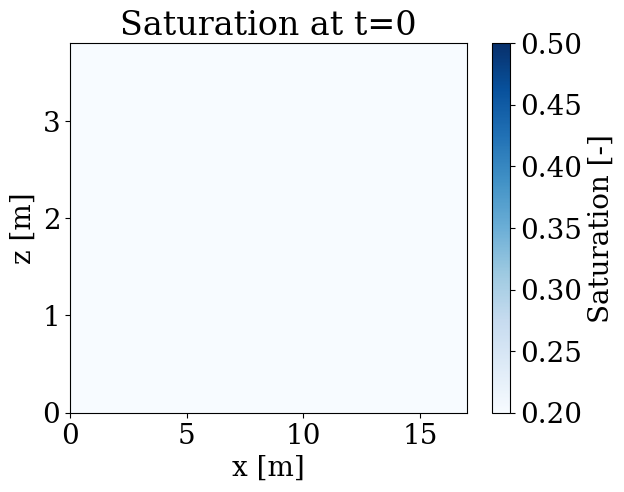

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -336.2192613768542, vmax: -0.03329417625755551


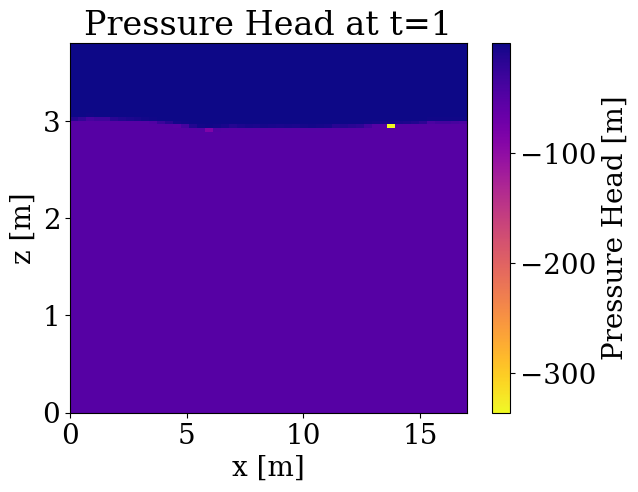

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.20002379399670234, vmax: 0.4301263076030155


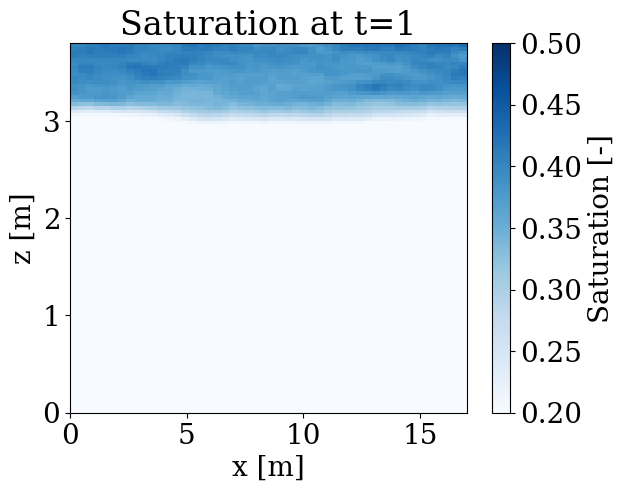

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -81.05157477886908, vmax: -0.02734501118674189


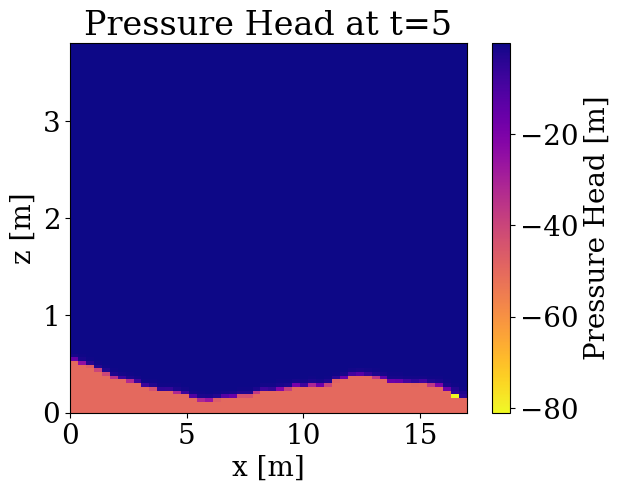

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.20009870258487805, vmax: 0.47476169116008454


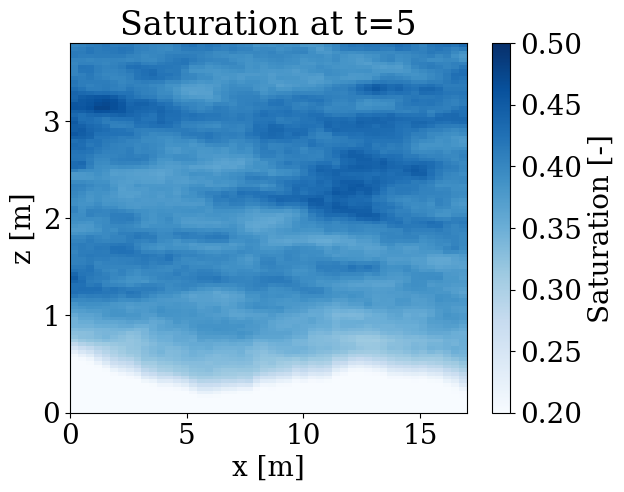

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -0.0504387360168389, vmax: 0.8252163545967648


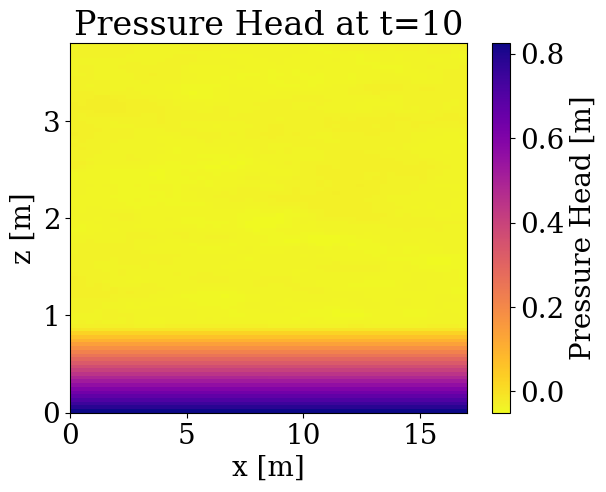

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.3555800238442235, vmax: 1.0


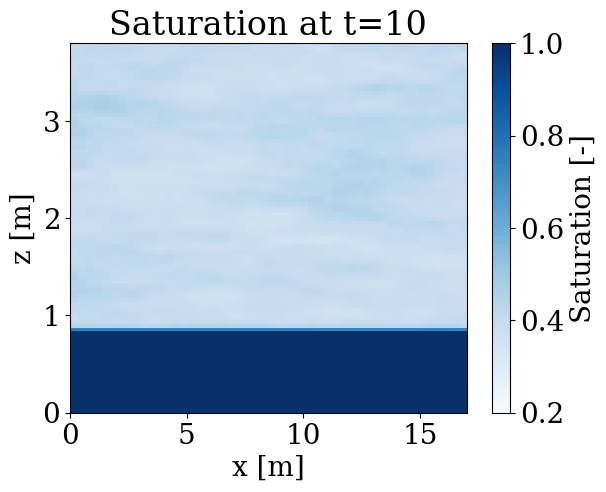

In [10]:
alpha_vG =100.0
correlated_random_field(alpha_vG,Sigma_input)
for time in time_array:
    #Saturation and pressure at time t = 0 hours
    plot_domain_corr_rnd(dir_name, "press", time,alpha_vG,Sigma_input); 
    plot_domain_corr_rnd(dir_name, "satur", time,alpha_vG,Sigma_input)

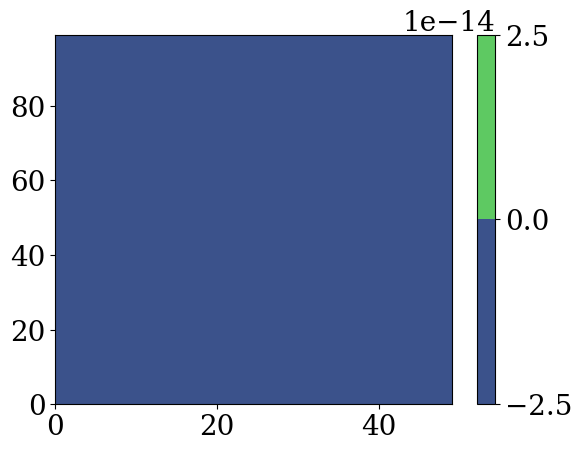

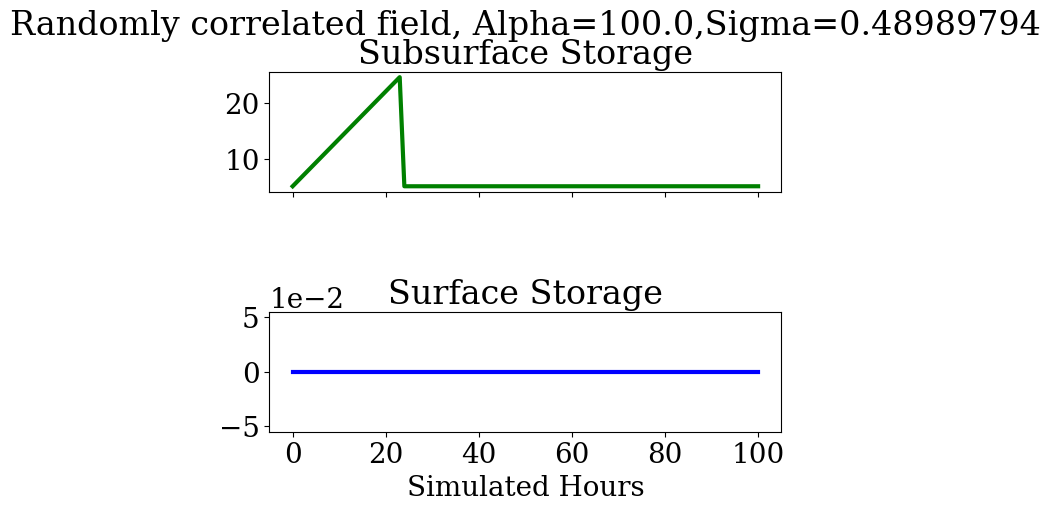

In [11]:
def surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input):
    run = Run.from_definition(f'{dir_name}/{run_name}.pfidb')
    data = run.data_accessor
    nt = len(data.times)
    nx = data.shape[2]
    ny = data.shape[1]
    nz = data.shape[0]
    dx = data.dx
    dy = data.dy
    dz = data.dz
    
    #print(nt,nx,ny,nz,dx,dy,dz)
    
    porosity = data.computed_porosity 
    specific_storage = data.specific_storage
    
    mannings = run.Mannings.Geom.domain.Value
    
    ## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
    ## this fixes a windows issue
    run.TopoSlopesX.FileName = None
    run.TopoSlopesY.FileName = None
    
    #slopex = data.slope_x 
    #slopey = data.slope_y 
    mask = data.mask
    
    # formatting the mask so that values outside the domain are NA and inside the domain are 1
    nanmask=mask.copy()
    nanmask[nanmask == 0] = 'NaN'
    nanmask[nanmask > 0] = 1

    plt.contourf(data.mask[:,0,:])
    plt.colorbar()

    #Combining all outputs
    files = glob(f"{dir_name}/{run_name}.out.satur.*.pfb")
    saturation_arrays = pf.read_pfb_sequence(files)
    files = glob(f"{dir_name}/{run_name}.out.press.*.pfb")
    pressure_arrays = pf.read_pfb_sequence(files)

    subsurface_storage = np.zeros(nt+1)
    surface_storage = np.zeros(nt+1)
    data.time = 0

    
    for i, (pressure, saturation) in enumerate(zip(pressure_arrays, saturation_arrays)):
        subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask = None),axis=(0, 1, 2))
        # total surface storage for this time step is the summation of substorage surface across all x/y slices
        surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure, dx, dy, mask = None),axis=(0, 1))
        data.time = i
        #print(subsurface_storage[i, ...])
        #print(i,np.sum(porosity*saturation*dx*dy*dz[0]*(1+specific_storage)))

    np.savez(f'Rnd_corr_fields_surface_subsurface_storage_alphavG{alpha_vG}_sigma{Sigma_input}',subsurface_storage,surface_storage)  
    
    #plotting components of water balance
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle(f'Randomly correlated field, Alpha={alpha_vG},Sigma={Sigma_input}')
    axs[0].plot(subsurface_storage[:-1], linewidth=3, color = "green")
    axs[0].set_title("Subsurface Storage")
    axs[1].plot(surface_storage[:-1], linewidth=3, color = "blue")
    axs[1].set_title("Surface Storage")
    plt.xlabel('Simulated Hours')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.85, 
                        wspace=0.7, 
                        hspace=1.0)
    axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.savefig(f'Rnd_corr_fields_surface_subsurface_storage_alphavG{alpha_vG}_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)

surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input)

/tmp/ipykernel_973658/698498494.py:3: RuntimeWarning: invalid value encountered in divide
  print((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100)
/tmp/ipykernel_973658/698498494.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100,color=blue)


[7.33196089 6.34034808 5.59460783 4.9999449  4.52409086 4.17004206
 3.83448295 3.54482722 3.3281737  3.11311534 2.92261123 2.69238866
 2.52620506 2.39561908 2.28302466 2.17310808 2.08311207 1.99599991
 1.9134598  1.84200291 1.77284633 1.70093697 1.64093359 1.57273275
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

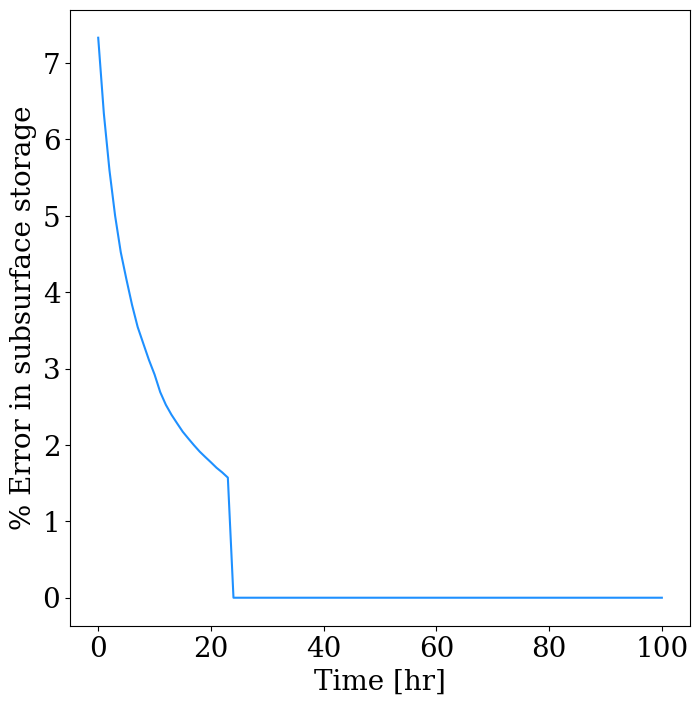

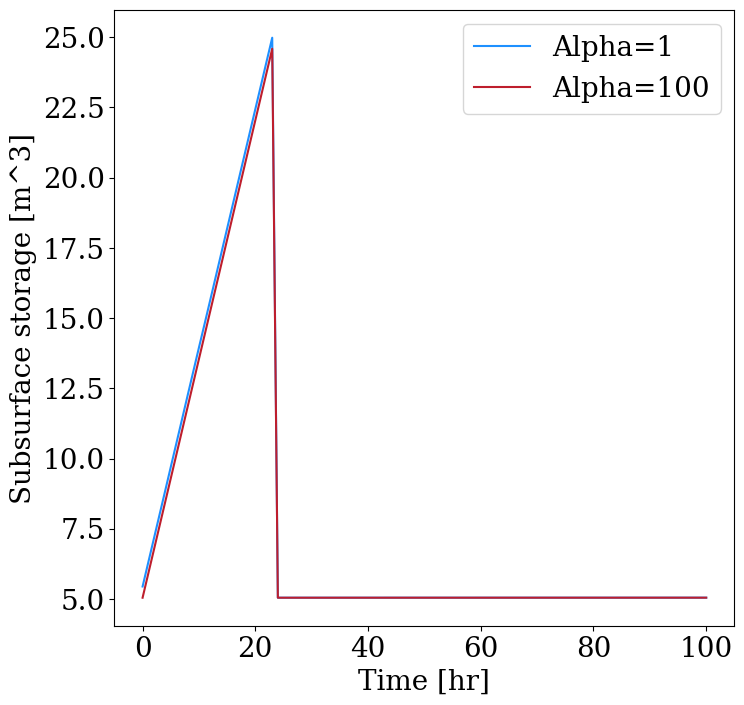

In [12]:
subsurface_storagealphavG100 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG100.0_sigma{Sigma_input}.npz');   subsurf_storage100   = subsurface_storagealphavG100['arr_0']
subsurface_storagealphavG1 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG1.0_sigma{Sigma_input}.npz');       subsurf_storage1   = subsurface_storagealphavG1['arr_0']
print((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100,color=blue)
plt.xlabel('Time [hr]')
plt.ylabel('% Error in subsurface storage')
plt.savefig(f'Rnd_corr_fields_Error__subsurface_storage_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot(subsurf_storage1[:-1],label='Alpha=1',color=blue)
plt.plot(subsurf_storage100[:-1],label='Alpha=100',color=red)
plt.xlabel('Time [hr]')
plt.ylabel('Subsurface storage [m^3]')
plt.legend()
plt.savefig(f'Rnd_corr_fields_subsurface_storage_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)

## Difference in the contours for 1*sigma variance

In [13]:
import numpy as np
#Difference the two contours
def difference_plot(time):
    #print(data)
    data = np.load(f'Rnd_corr_fields_satur_alphavG1.0_time{time}_sigma{Sigma_input}.npz')
    x_faces = data['arr_0']; z_faces = data['arr_1']; press1_data_array = data['arr_2']
    x_center = np.convolve(x_faces, [0.5, 0.5], "valid"); z_center = np.convolve(z_faces, [0.5, 0.5], "valid")

    x_array, z_array = np.meshgrid(x_center,z_center)
    print(np.shape(x_array),np.shape(z_array),np.shape(press1_data_array))
   
    # plt.figure()
    # plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    # plt.colorbar()
    # plt.show
    data = np.load(f'Rnd_corr_fields_satur_alphavG1.0_time{time}_sigma{Sigma_input}.npz');   satur1_data_array   = data['arr_2']
    data = np.load(f'Rnd_corr_fields_press_alphavG100.0_time{time}_sigma{Sigma_input}.npz'); press100_data_array = data['arr_2']
    data = np.load(f'Rnd_corr_fields_satur_alphavG100.0_time{time}_sigma{Sigma_input}.npz'); satur100_data_array = data['arr_2']
    
    variable_array = ["satur","press"] #satur or press
    
    for variable in variable_array:
        fig = plt.figure(figsize=(8,8) , dpi=100)
        if variable == "satur":
            label = "Saturation [-]"
            title = "Saturation [-]"
        elif variable == "press":
            label = "Pressure Head [m]"
            title = "Pressure Head [m]"
        elif variable == "porosity":
            label = "Porosity"
            title = "Porosity"
    
        if variable == "satur":
            im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
        else:
            im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')        
        plt.xlabel(f"x [m]")
        cbar = fig.colorbar(im)
    
        cbar.ax.set_ylabel(f"Difference in {title}")
        plt.ylabel('z [m]')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.legend(loc='best', frameon=False)
        plt.savefig(f'Rnd_corr_fields_{variable}_contour_difference_time{time}_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)

(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


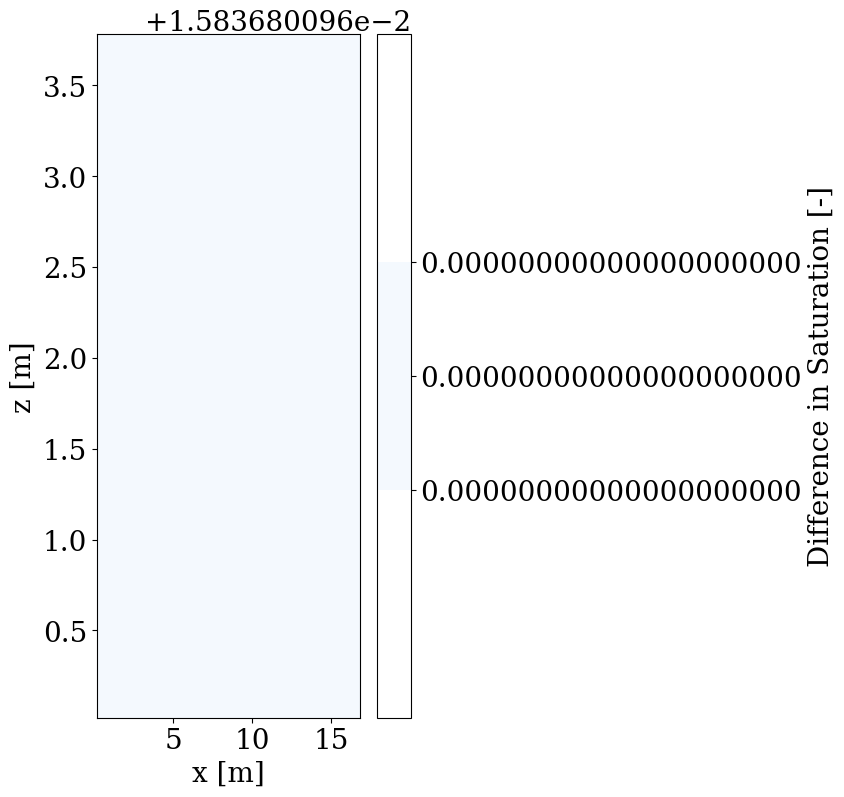

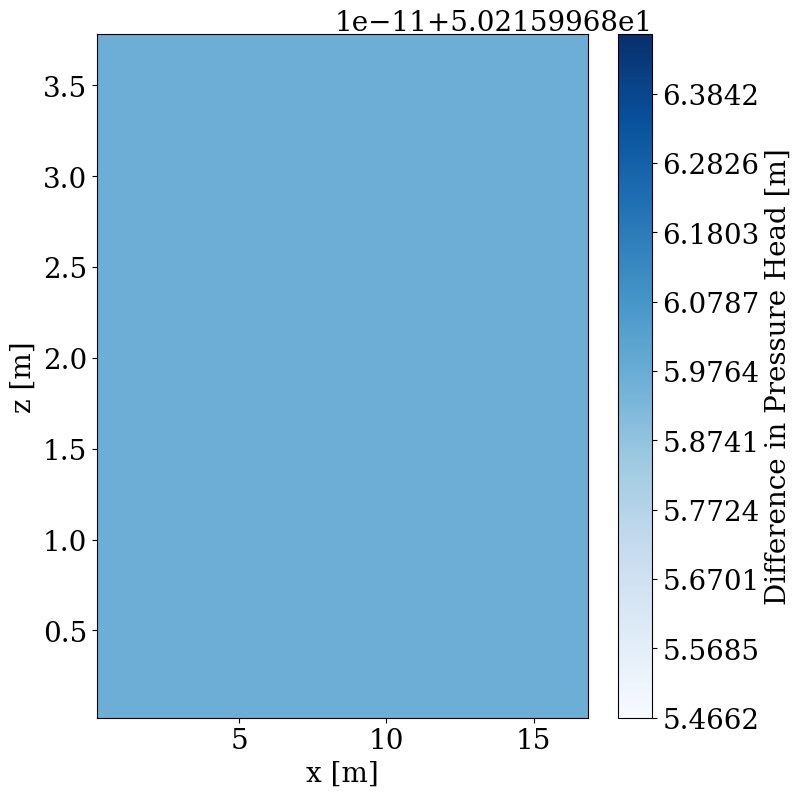

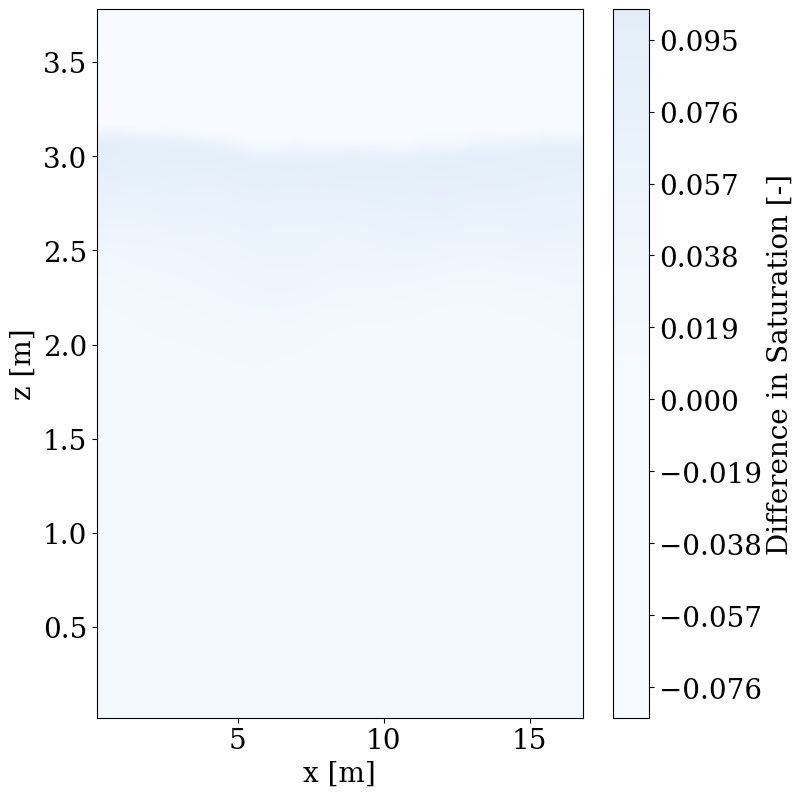

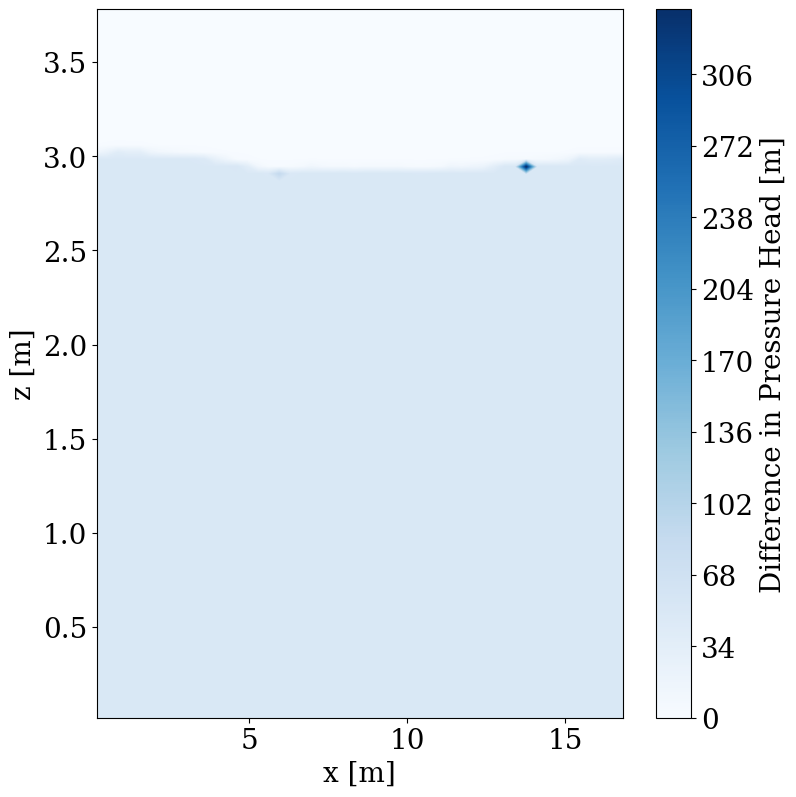

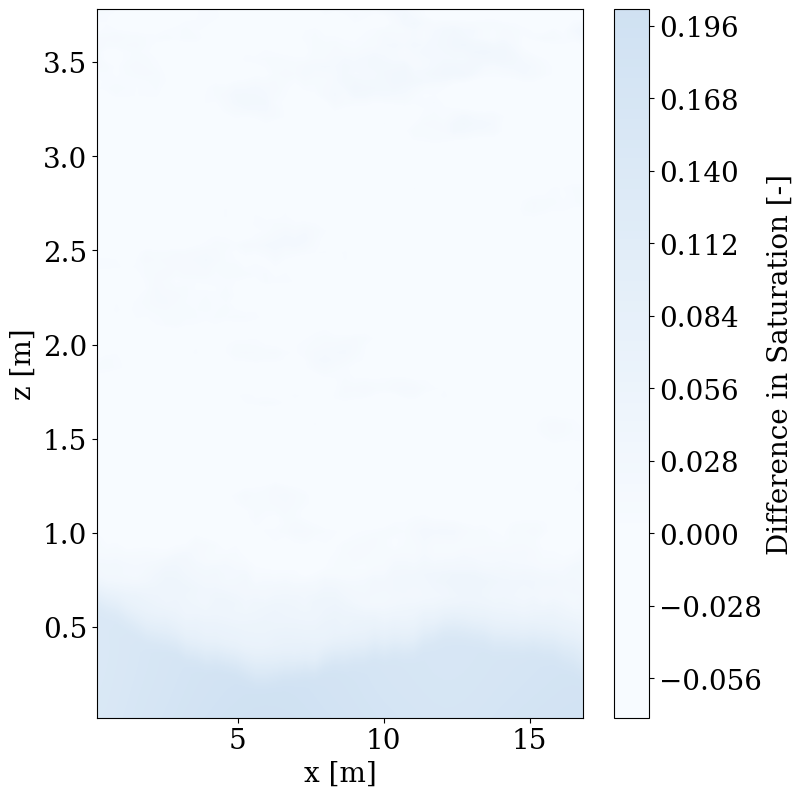

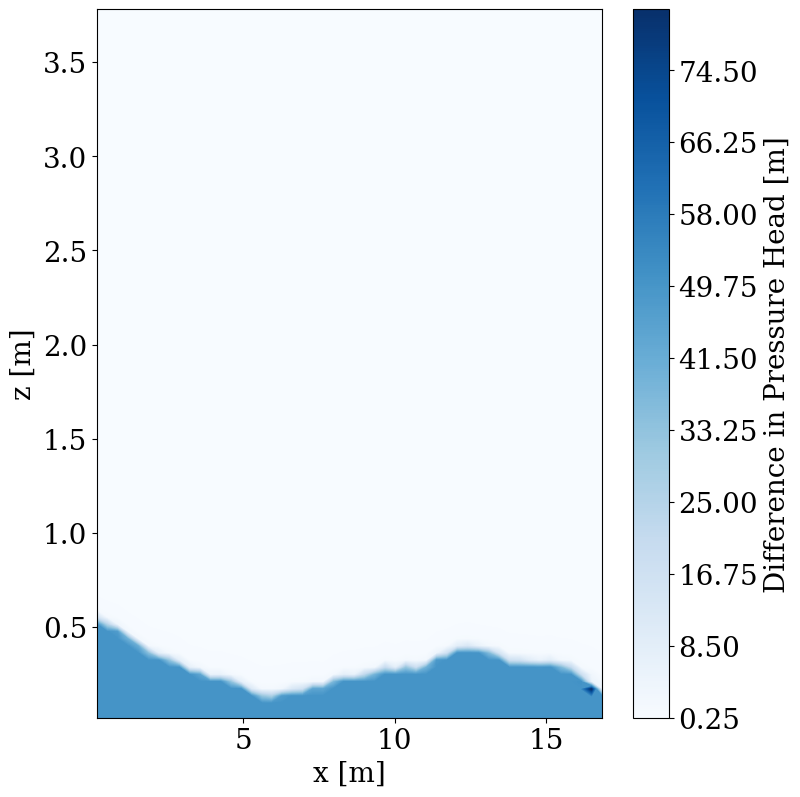

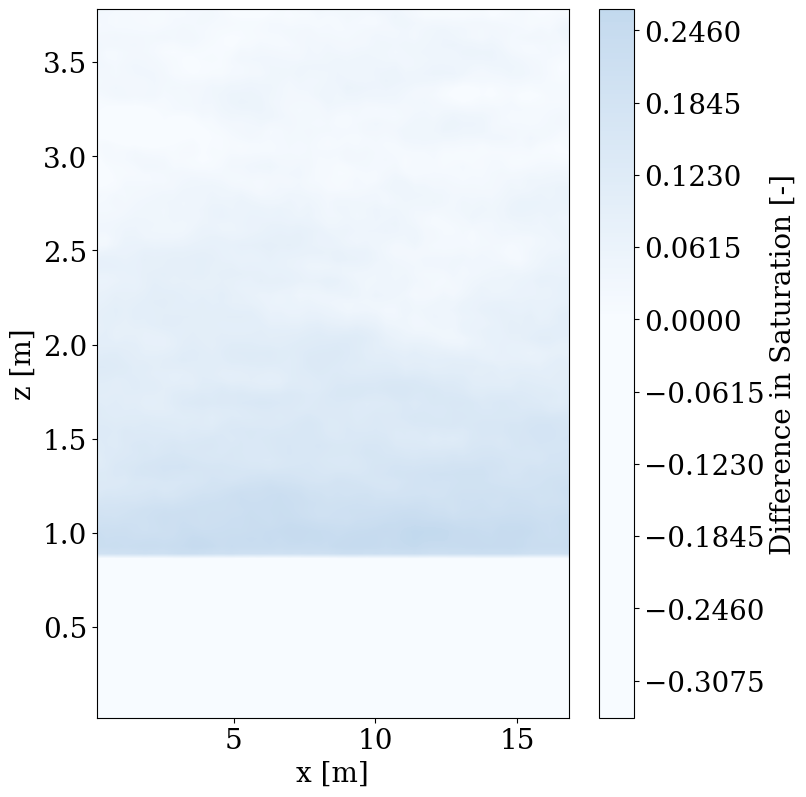

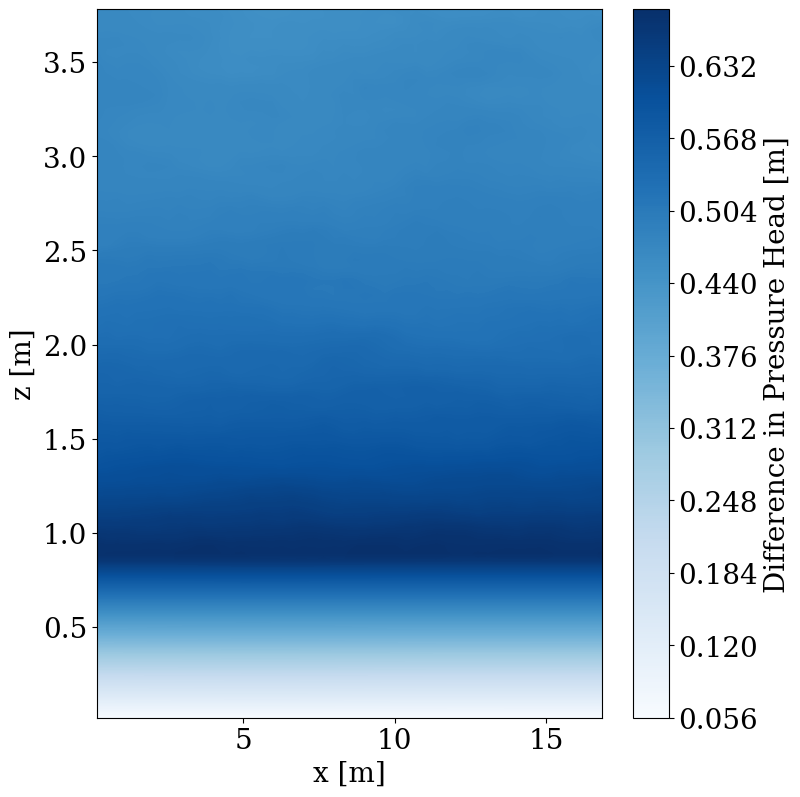

In [14]:
for time in time_array:
    #Saturation and pressure difference at time t = 0 hours
    difference_plot(time)

### Alpha = 1.0 (With capillarity), Deviation = 2 * sigma


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.39, vmax: 0.39


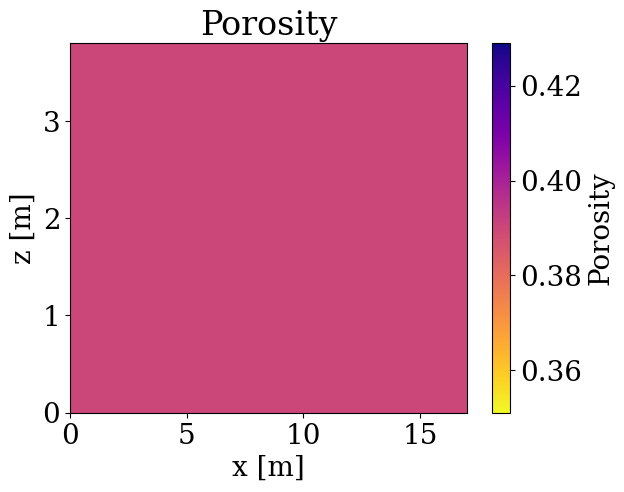

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 4.032316149699939, vmax: 1455.7277725832712


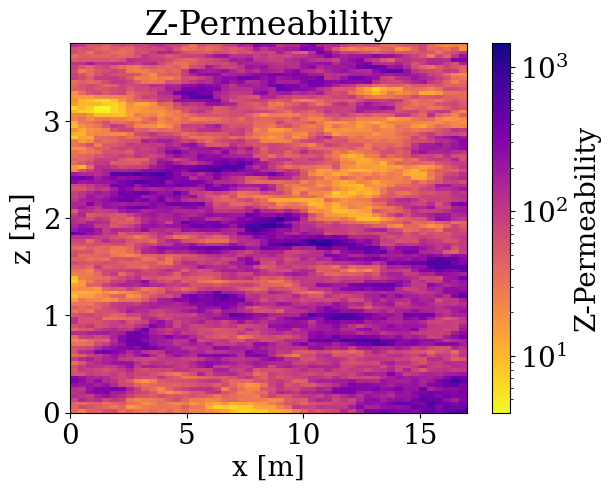

In [15]:
alpha_vG =1.0
time_array = [0, 1, 5, 10]
Sigma_input = 2*0.48989794
correlated_random_field(alpha_vG,Sigma_input)
plot_domain_corr_rnd(dir_name, "porosity", 0,Sigma_input)
plot_domain_corr_rnd(dir_name, "z-permeability", 0,Sigma_input)

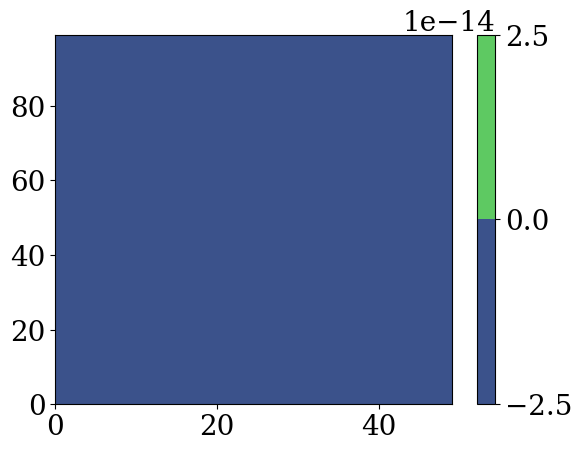

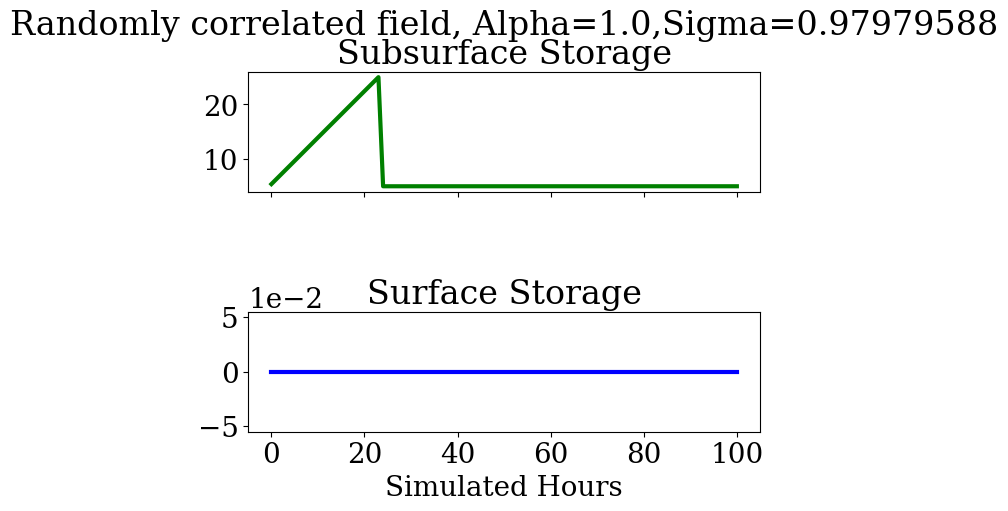

In [16]:
surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input)

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.0, vmax: -50.0


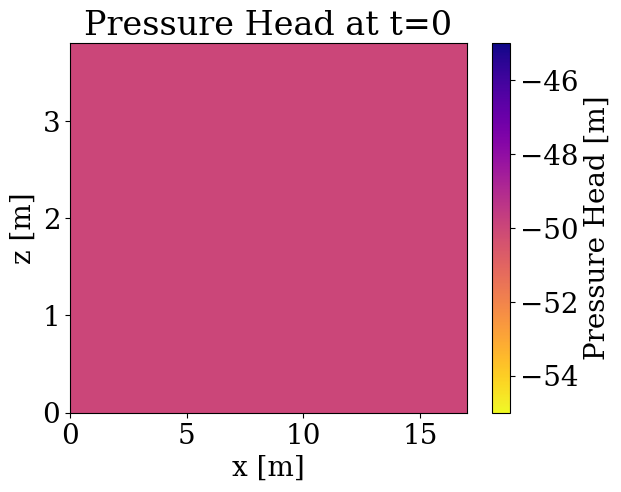

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.21599680095968013, vmax: 0.21599680095968013


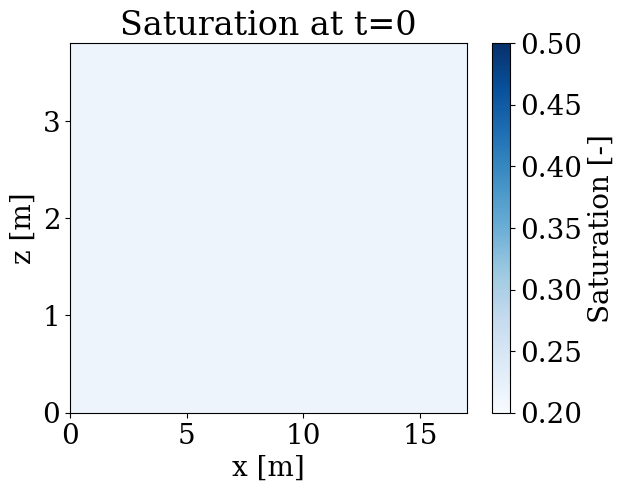

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.05939192270121, vmax: -4.186365509063628


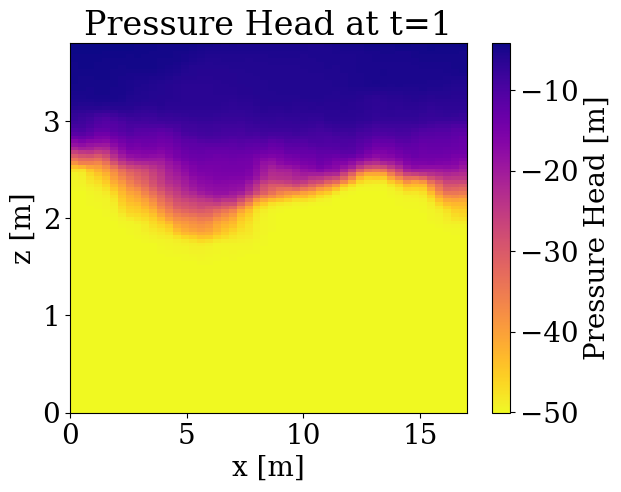

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.21597782946352828, vmax: 0.38586738431283857


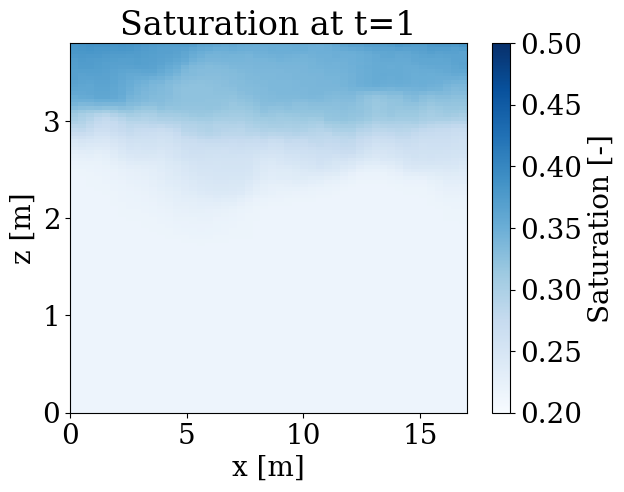

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -12.338167090363227, vmax: -2.81476438272034


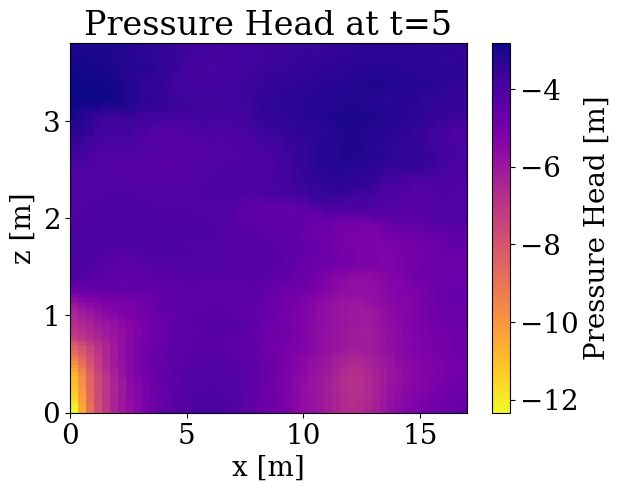

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.264627531185342, vmax: 0.4678163025103346


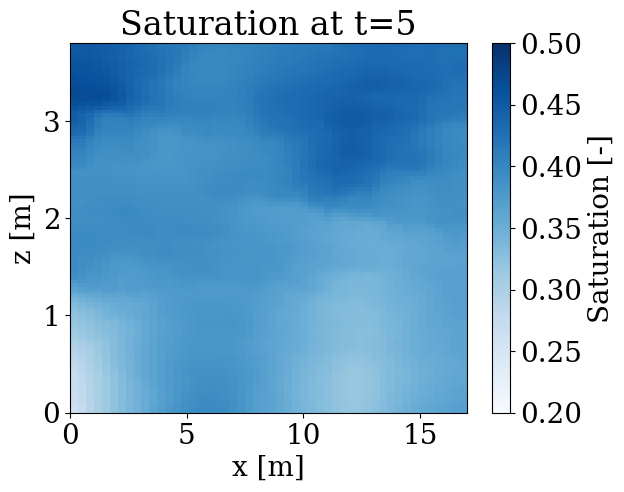

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -3.5390854122540842, vmax: -0.6532925719575974


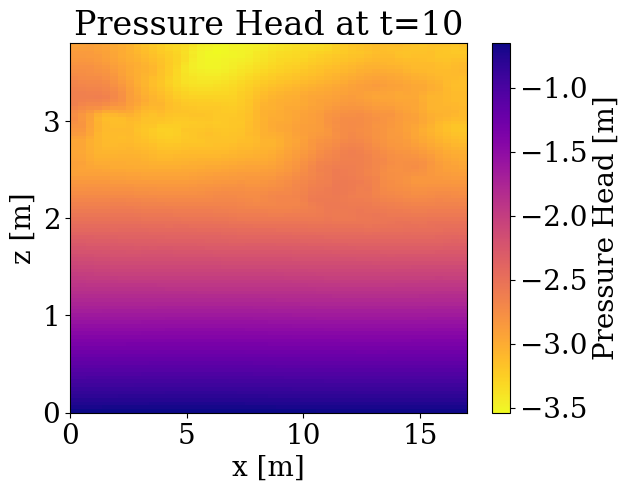

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.4175300873760429, vmax: 0.8697454599347545


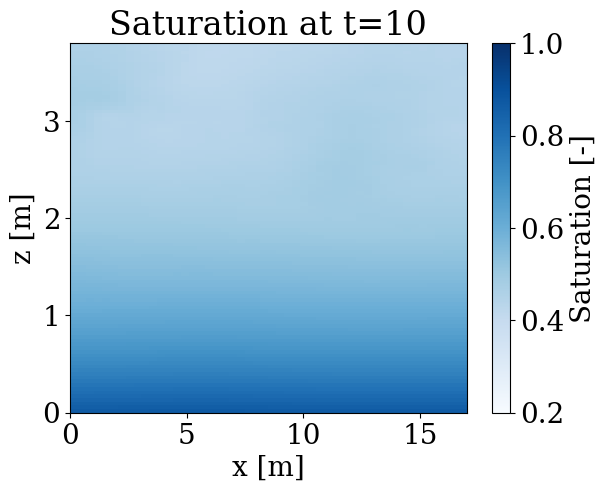

In [17]:
alpha_vG =1.0
for time in time_array:
    #Saturation and pressure at time t = 0 hours
    plot_domain_corr_rnd(dir_name, "press", time,alpha_vG,Sigma_input); 
    plot_domain_corr_rnd(dir_name, "satur", time,alpha_vG,Sigma_input)

##### Alpha = 100.0 (Without capillarity), Deviation = 2 * sigma


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.0, vmax: -50.0


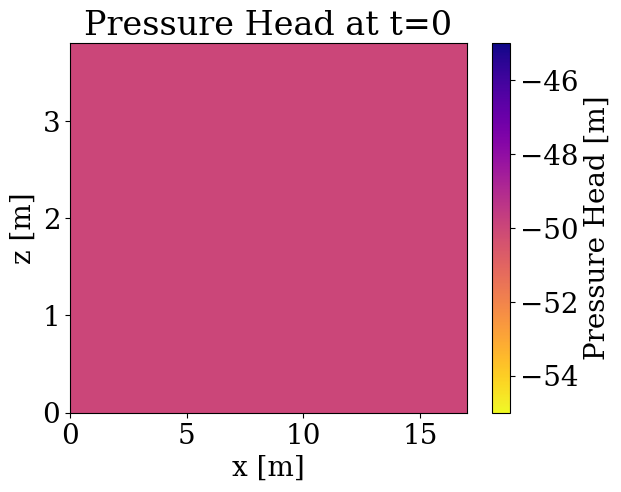

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.2001599999968, vmax: 0.2001599999968


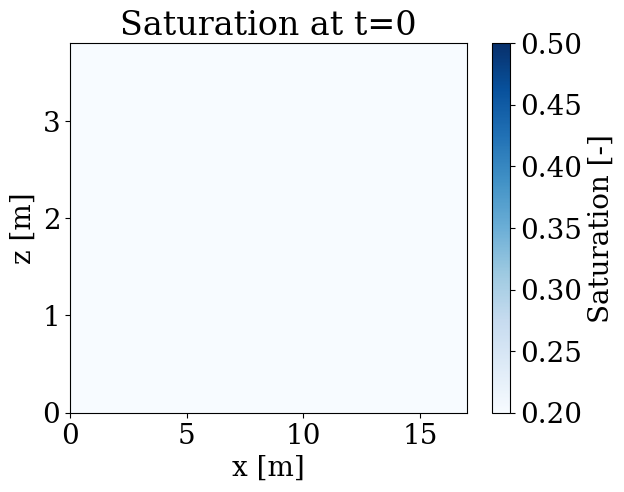

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -10124.943451100618, vmax: -0.026970363080378007


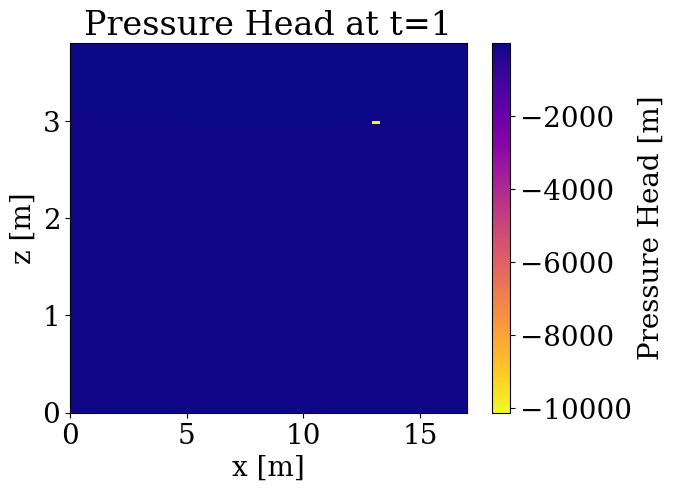

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.20000079012786973, vmax: 0.47811992366155026


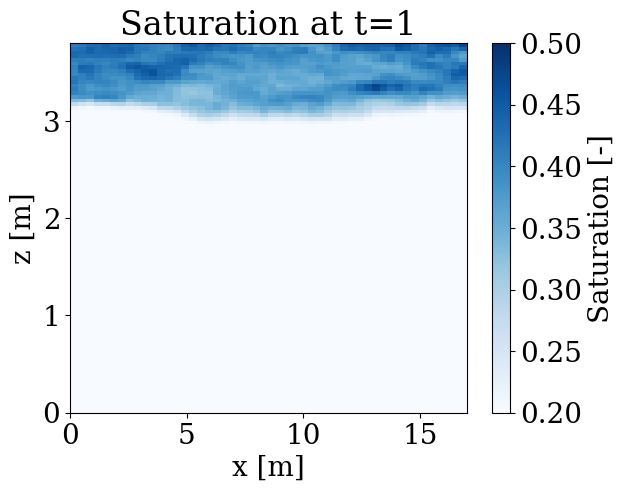

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -2387.647784722263, vmax: -0.018077563490289612


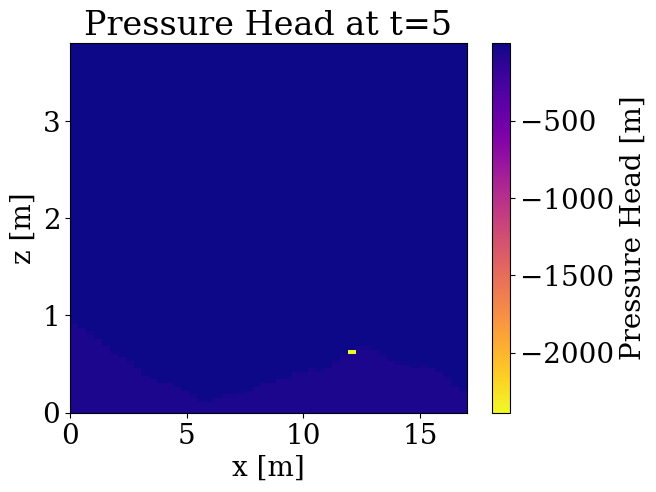

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.20000335057794166, vmax: 0.5872386038553921


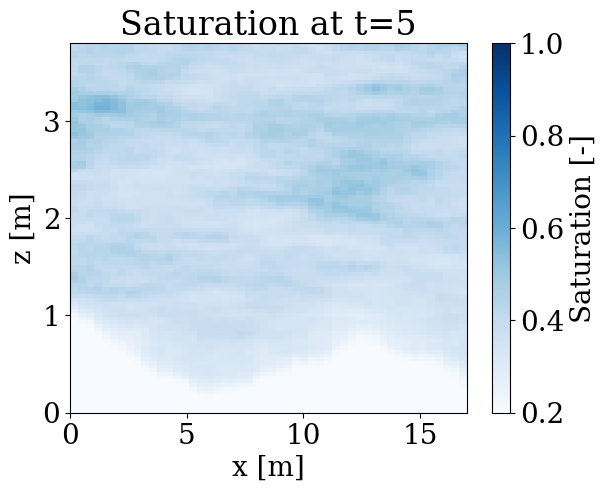

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -0.0628852475292653, vmax: 0.7769935169967933


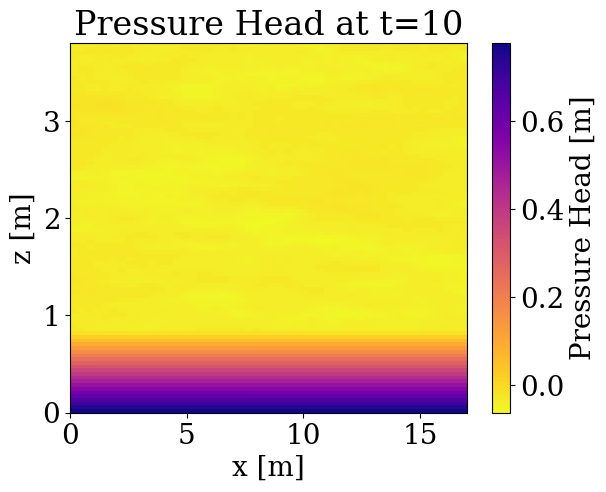

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.3256372504708145, vmax: 1.0


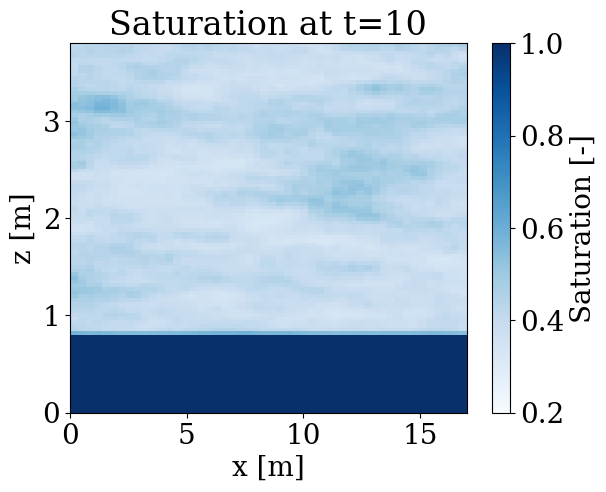

In [18]:
alpha_vG =100.0
correlated_random_field(alpha_vG,Sigma_input)
for time in time_array:
    #Saturation and pressure at time t = 0 hours
    plot_domain_corr_rnd(dir_name, "press", time,alpha_vG,Sigma_input); 
    plot_domain_corr_rnd(dir_name, "satur", time,alpha_vG,Sigma_input)

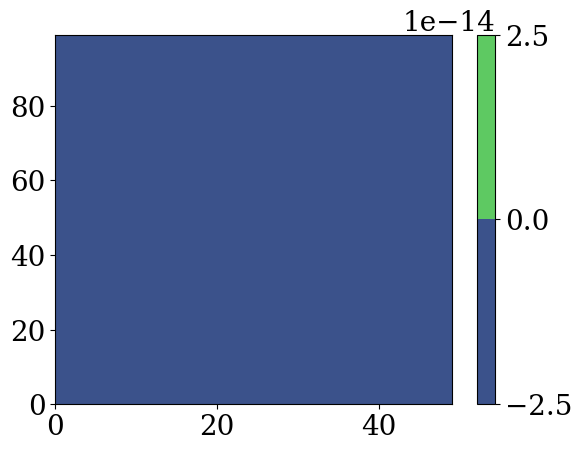

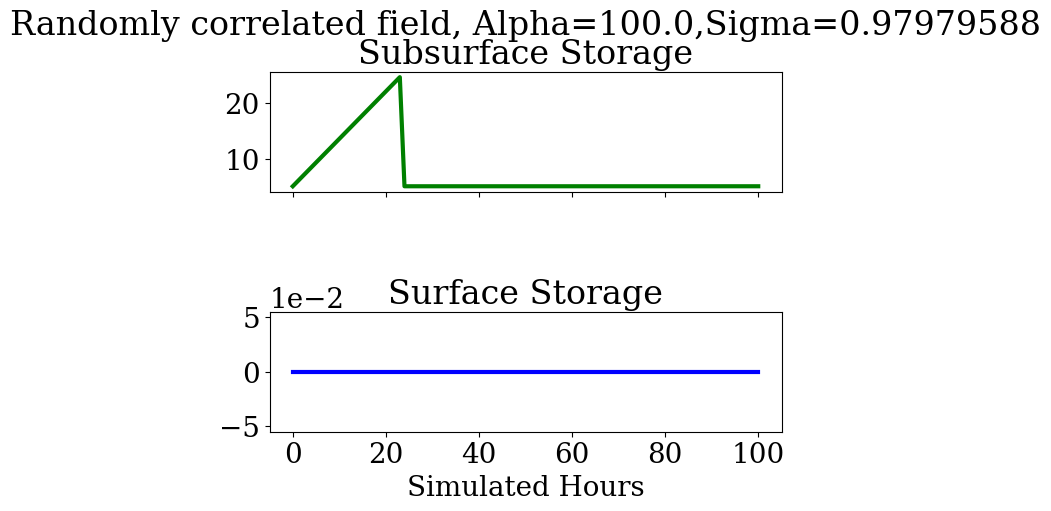

In [19]:
surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input)

/tmp/ipykernel_973658/698498494.py:3: RuntimeWarning: invalid value encountered in divide
  print((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100)
/tmp/ipykernel_973658/698498494.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100,color=blue)


[7.33196089 6.34296146 5.59117385 4.99649355 4.51663733 4.1204229
 3.78895324 3.51020736 3.27210819 3.07860142 2.89263628 2.7224725
 2.57411381 2.44311875 2.32416885 2.21584118 2.11903836 2.0273979
 1.93987391 1.86315903 1.79465254 1.73045021 1.66763604 1.60974664
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.  

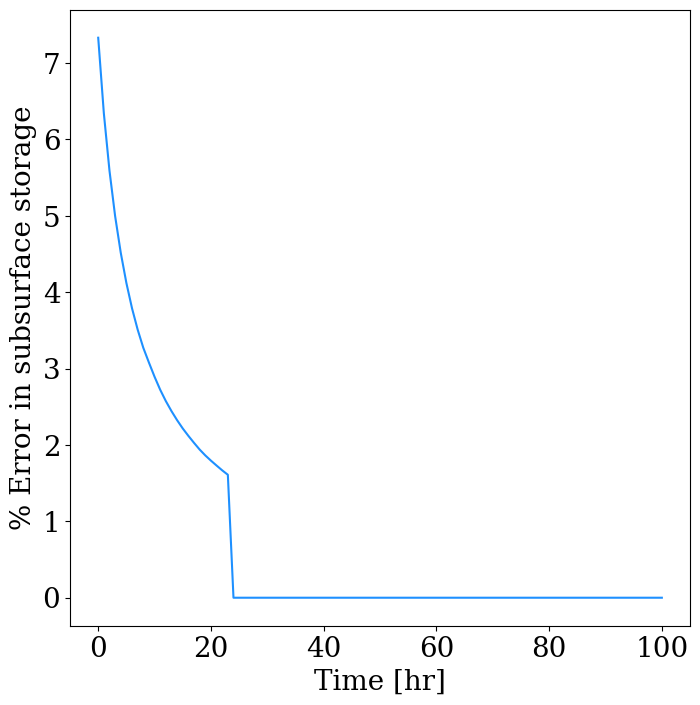

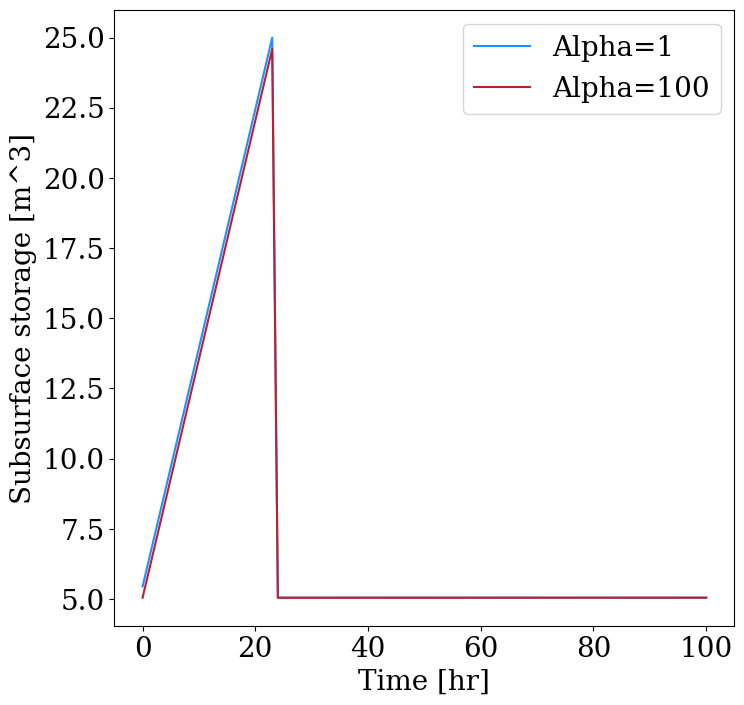

In [20]:
subsurface_storagealphavG100 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG100.0_sigma{Sigma_input}.npz');   subsurf_storage100   = subsurface_storagealphavG100['arr_0']
subsurface_storagealphavG1 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG1.0_sigma{Sigma_input}.npz');       subsurf_storage1   = subsurface_storagealphavG1['arr_0']
print((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100,color=blue)
plt.xlabel('Time [hr]')
plt.ylabel('% Error in subsurface storage')
plt.savefig(f'Rnd_corr_fields_Error__subsurface_storage_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot(subsurf_storage1[:-1],label='Alpha=1',color=blue)
plt.plot(subsurf_storage100[:-1],label='Alpha=100',color=red)
plt.xlabel('Time [hr]')
plt.ylabel('Subsurface storage [m^3]')
plt.legend()
plt.savefig(f'Rnd_corr_fields_subsurface_storage_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)

## Difference in the contours for 2*sigma variance

(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


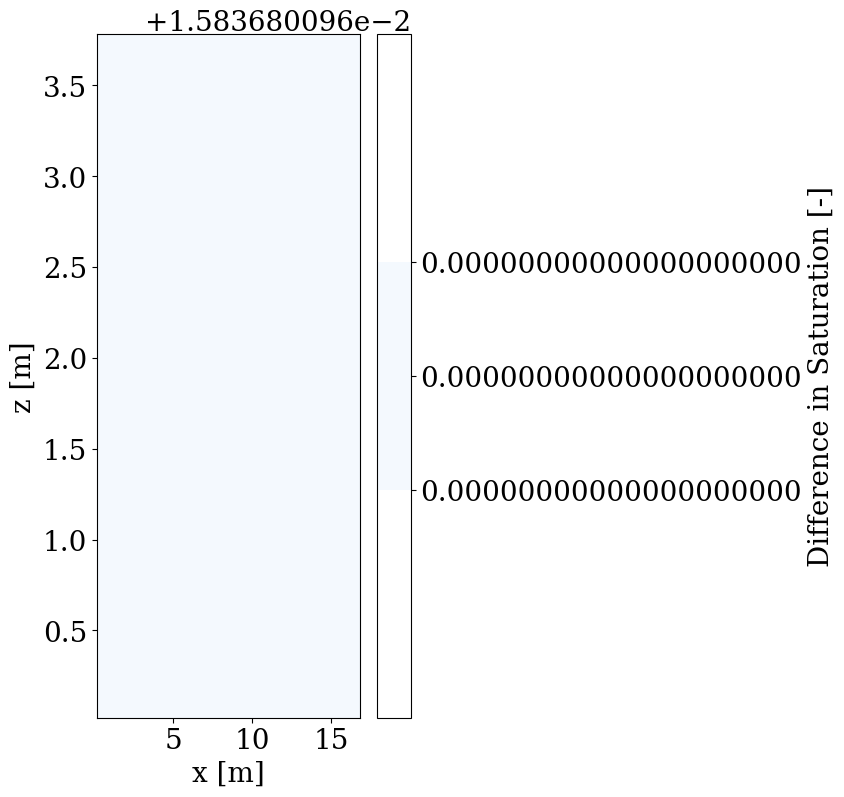

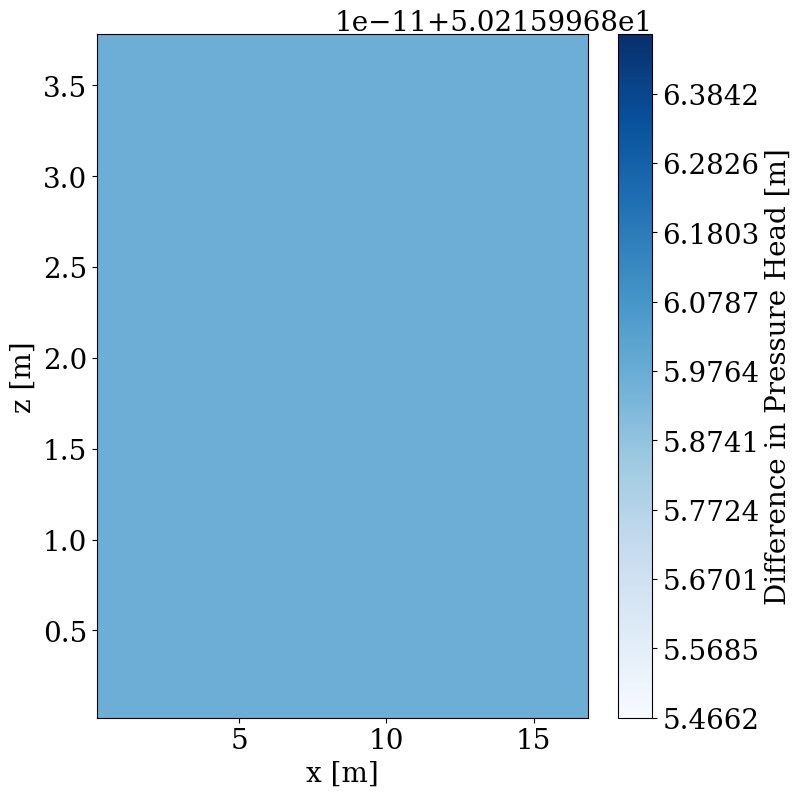

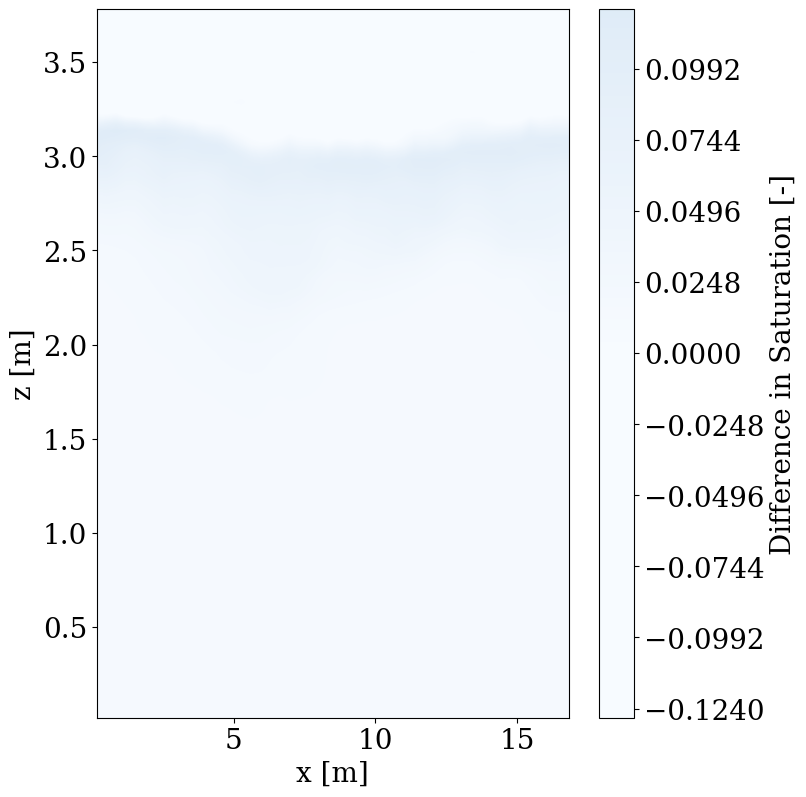

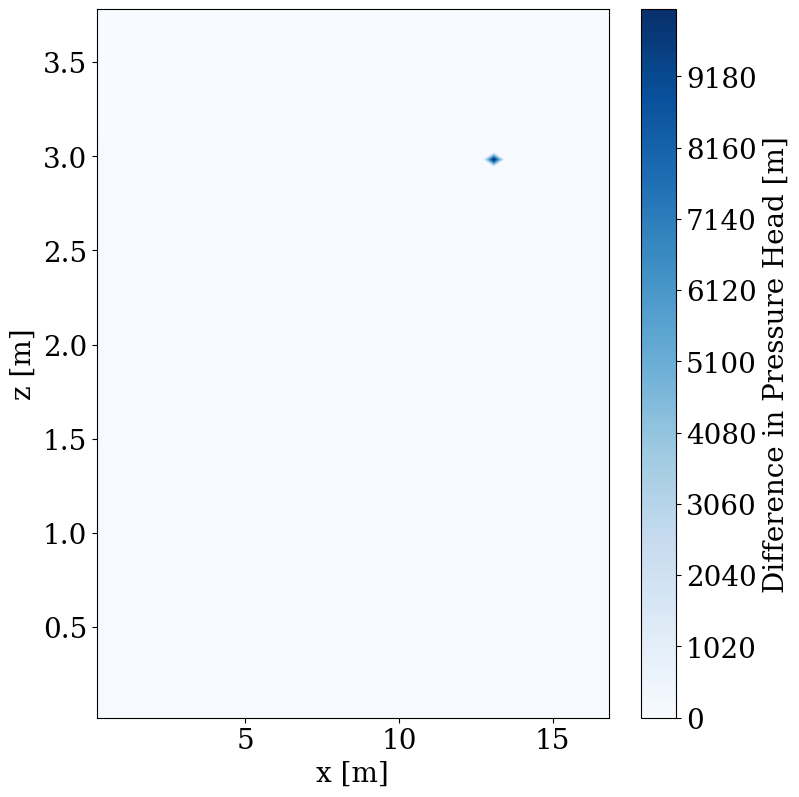

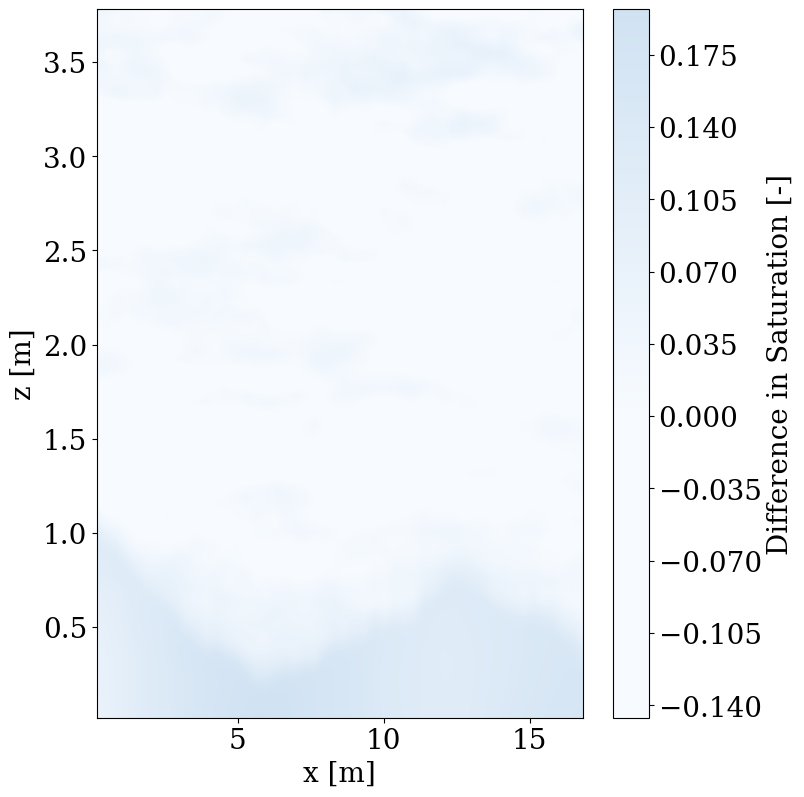

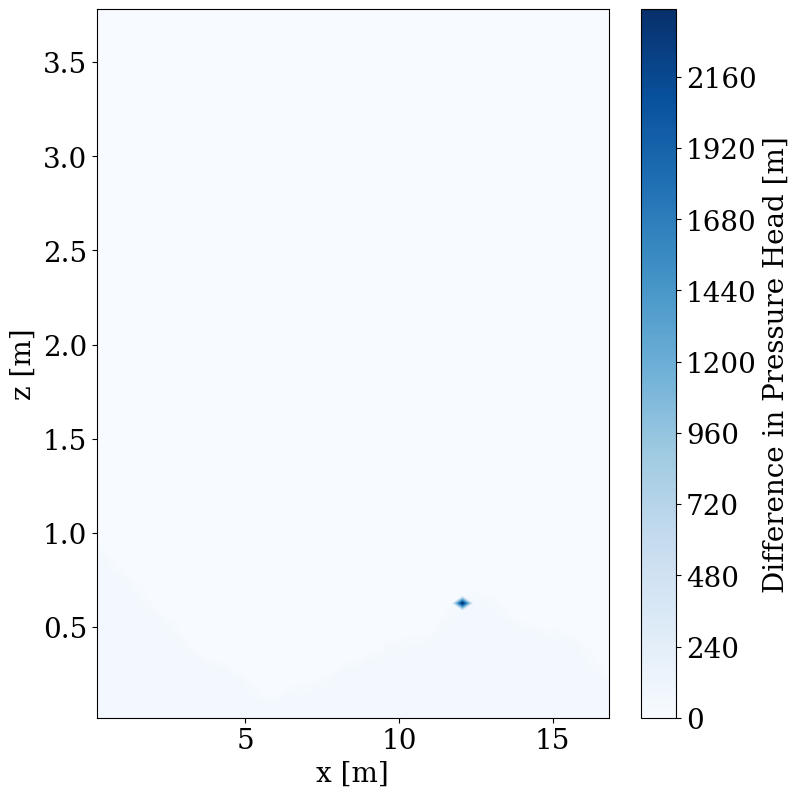

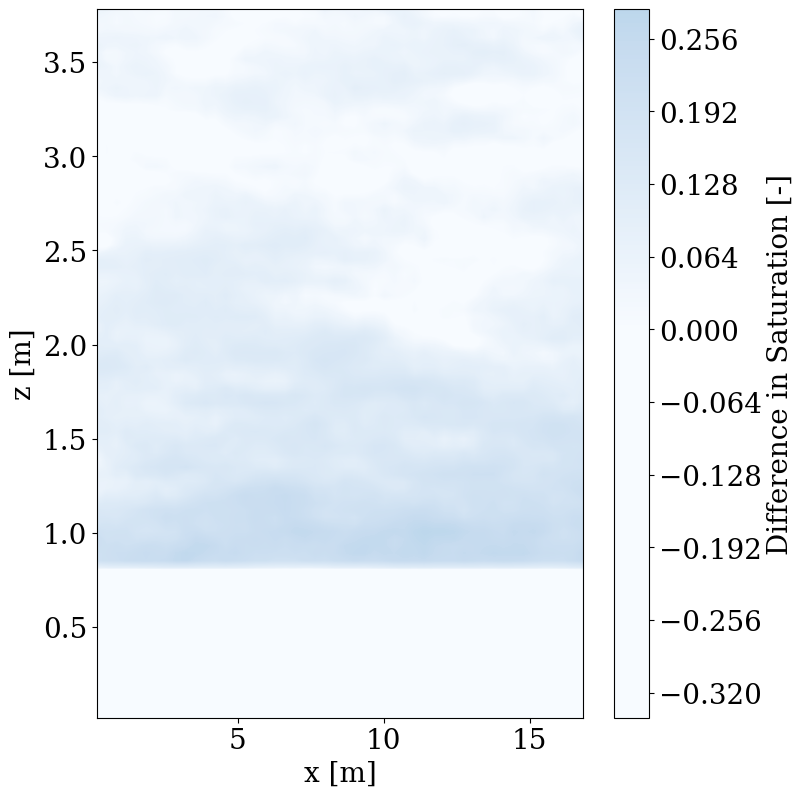

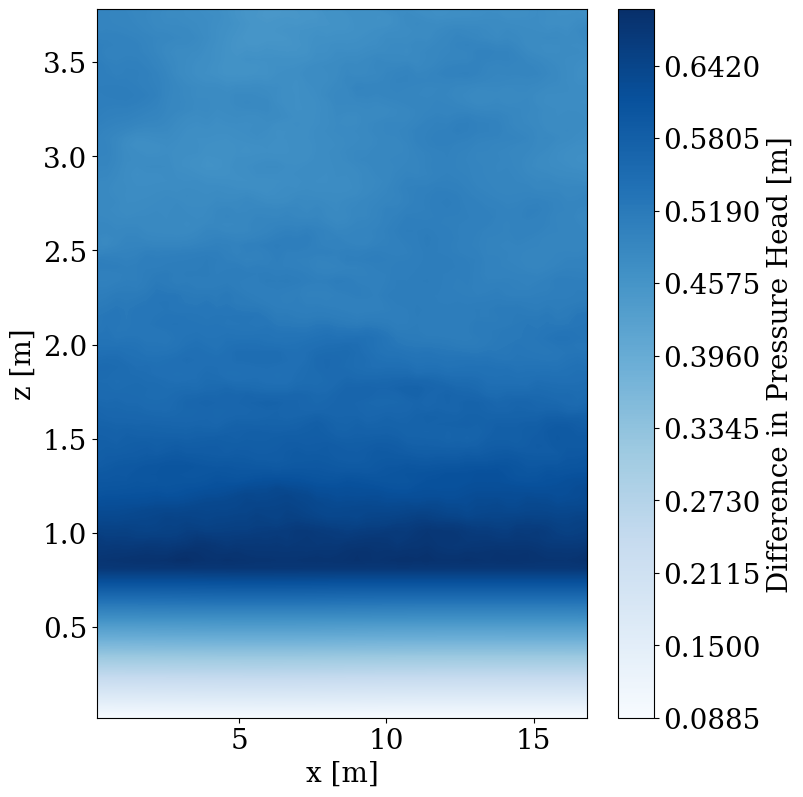

In [21]:
for time in time_array:
    #Saturation and pressure difference at time t = 0 hours
    difference_plot(time)

### Alpha = 1.0 (With capillarity), Deviation = 5 * sigma


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.39, vmax: 0.39


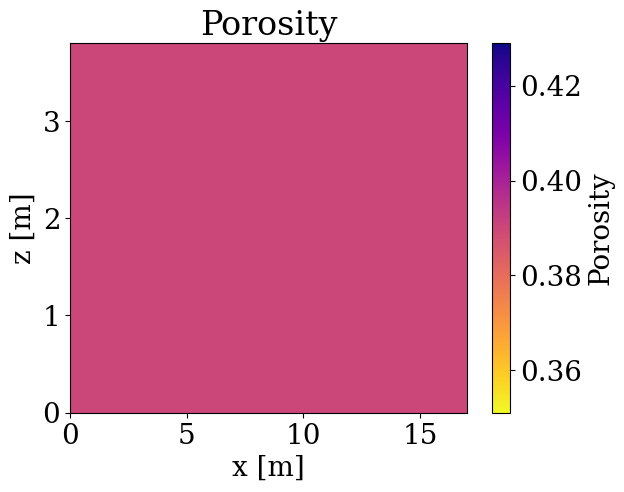

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.02754605460013273, vmax: 68213.97929298432


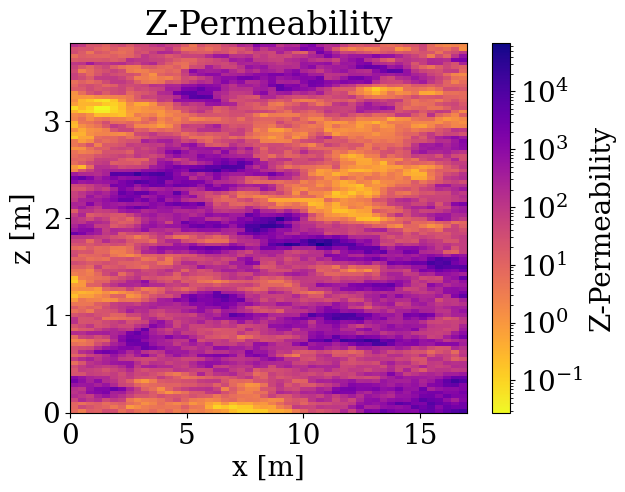

In [22]:
alpha_vG =1.0
time_array = [0, 1, 5, 10]
Sigma_input = 5*0.48989794
correlated_random_field(alpha_vG,Sigma_input)
plot_domain_corr_rnd(dir_name, "porosity", 0,Sigma_input)
plot_domain_corr_rnd(dir_name, "z-permeability", 0,Sigma_input)

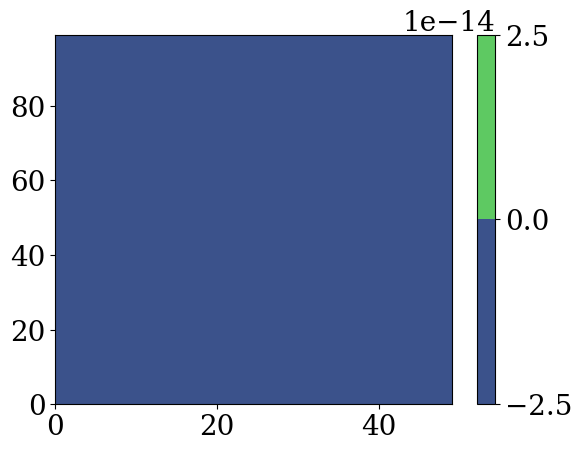

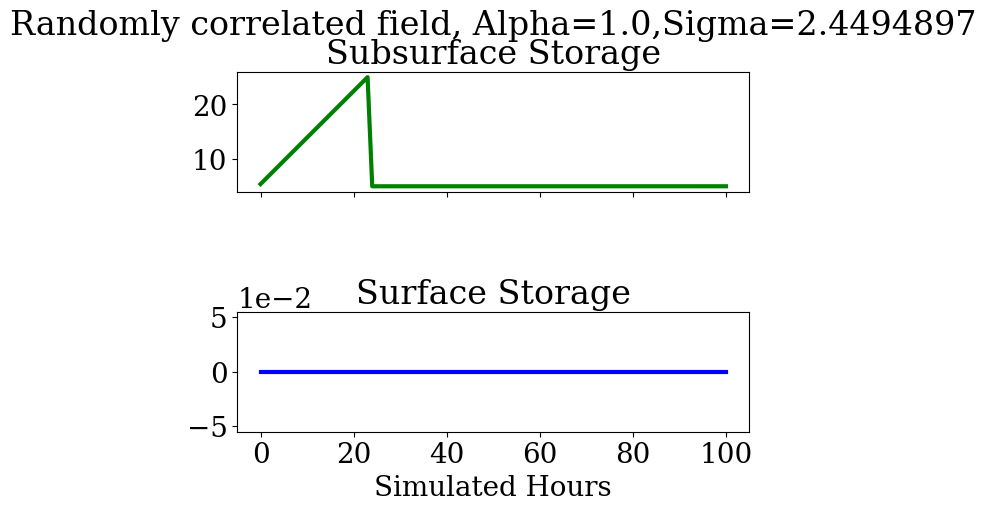

In [23]:
surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input)

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.0, vmax: -50.0


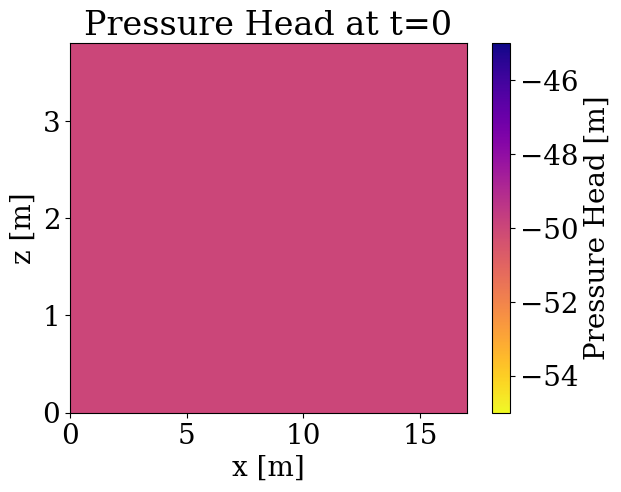

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.21599680095968013, vmax: 0.21599680095968013


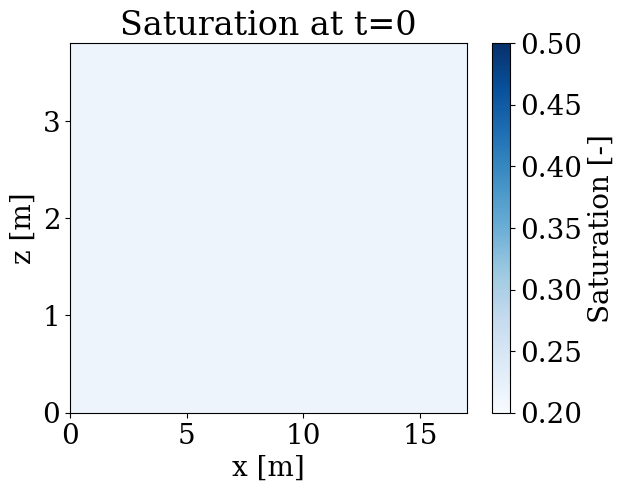

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.157765908499826, vmax: -2.7373894204540252


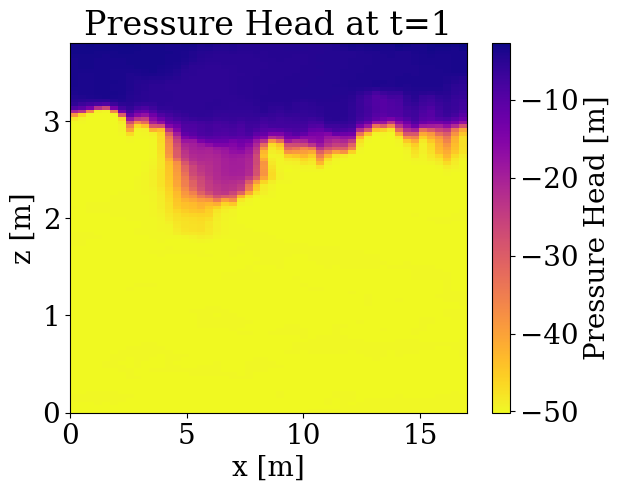

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.2159465047503369, vmax: 0.4745059316311581


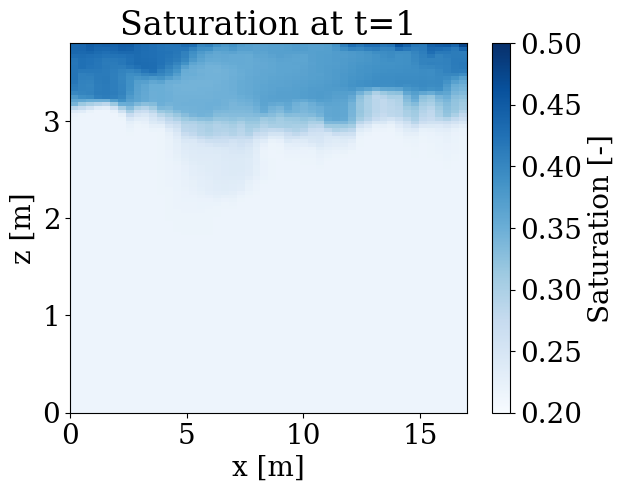

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.04597041470668, vmax: -1.2408480856465403


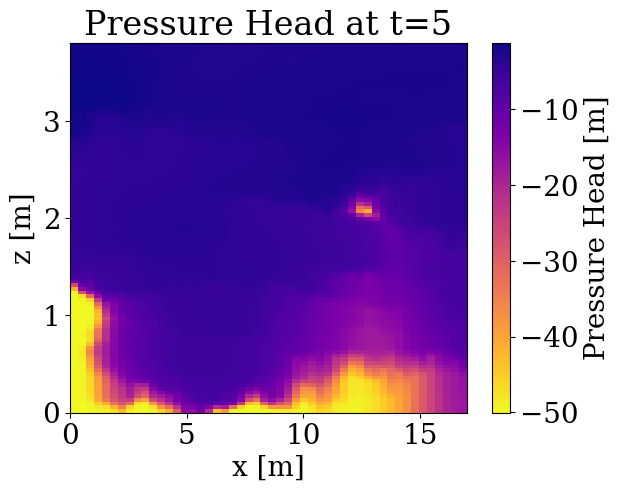

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.21598211274525173, vmax: 0.7019938978022624


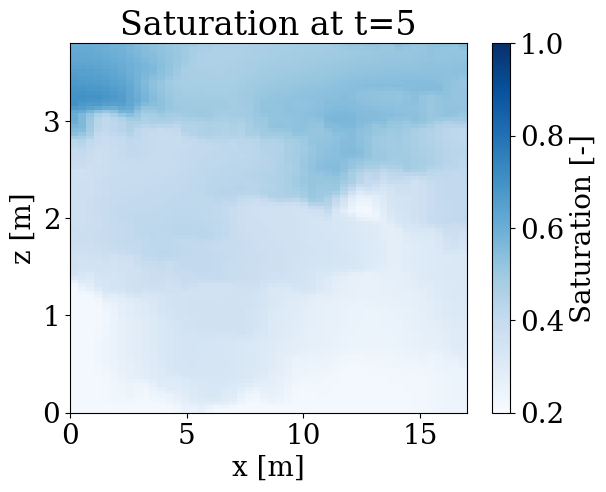

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -3.2516829247273566, vmax: -0.949775127682442


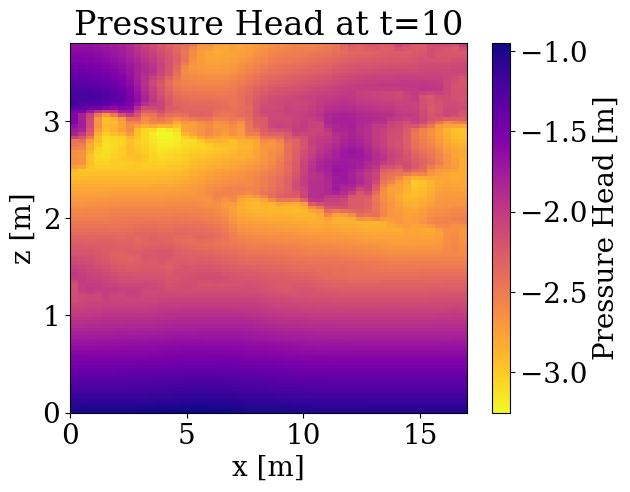

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.43515743810514224, vmax: 0.7800646773639022


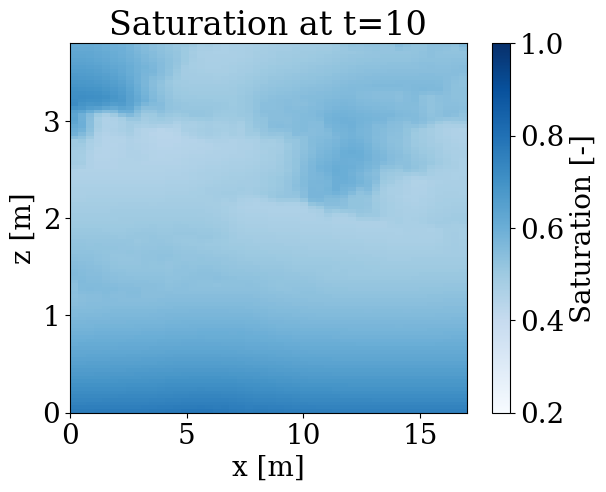

In [24]:
alpha_vG =1.0
for time in time_array:
    #Saturation and pressure at time t = 0 hours
    plot_domain_corr_rnd(dir_name, "press", time,alpha_vG,Sigma_input); 
    plot_domain_corr_rnd(dir_name, "satur", time,alpha_vG,Sigma_input)

### Alpha = 100.0 (Without capillarity), Deviation = 5 * sigma


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -50.0, vmax: -50.0


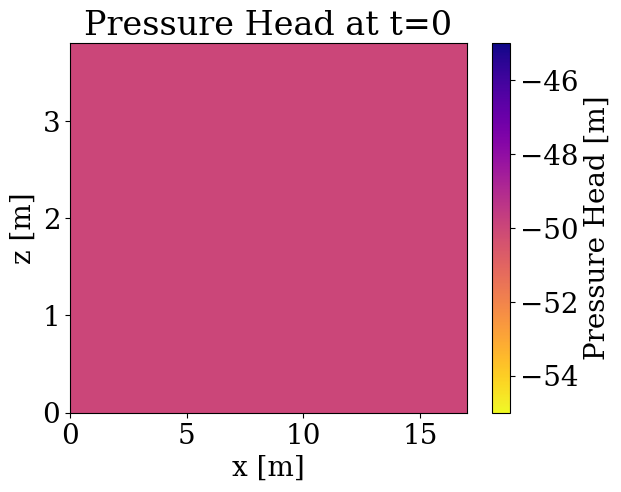

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.2001599999968, vmax: 0.2001599999968


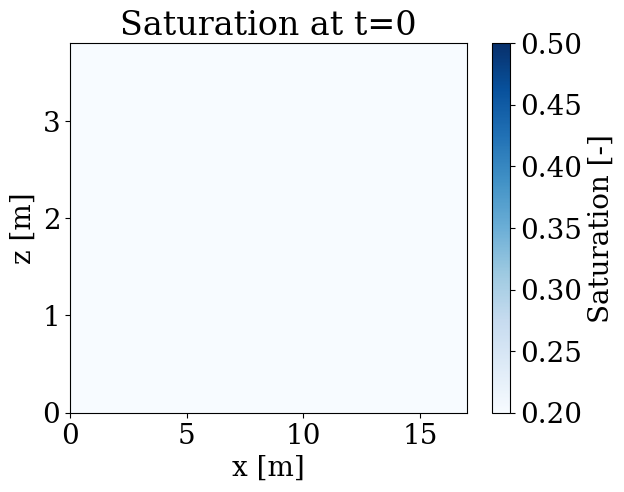

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -3923.6594466349525, vmax: -0.01065105645497604


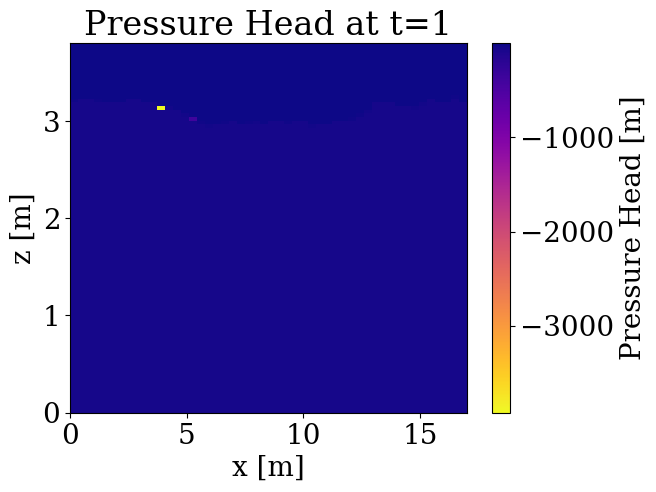

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.20000203891293544, vmax: 0.7475792598664448


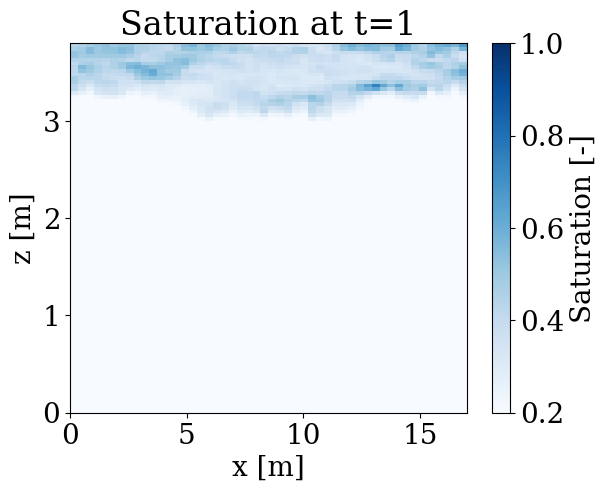

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -52.139609393170154, vmax: 0.01671020439243595


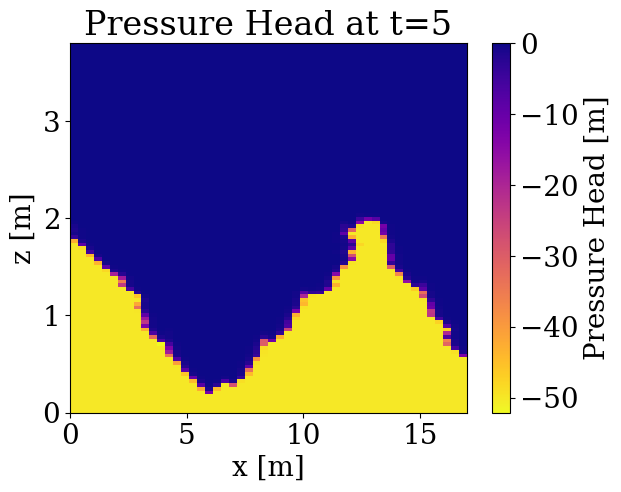

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.20015343421145596, vmax: 1.0


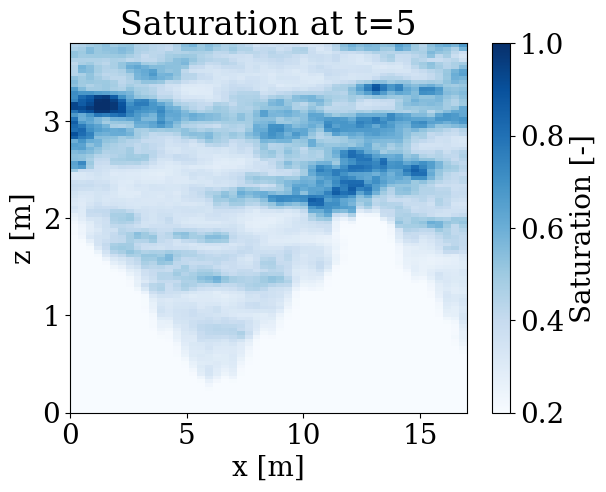

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: -0.10473527705568643, vmax: 0.5255463639840668


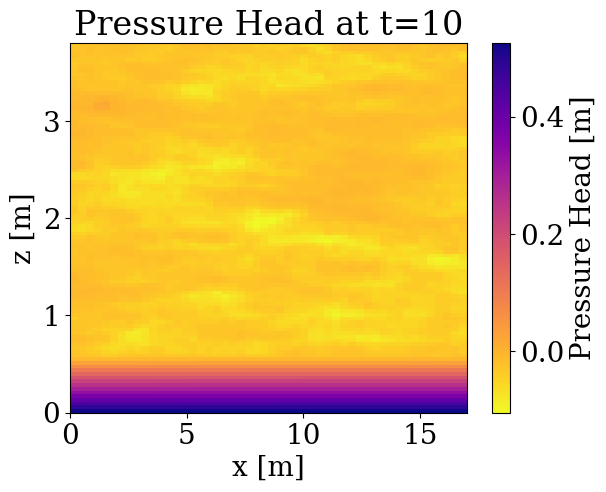

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 1.0, dz = 0.038
vmin: 0.2760372516782465, vmax: 1.0


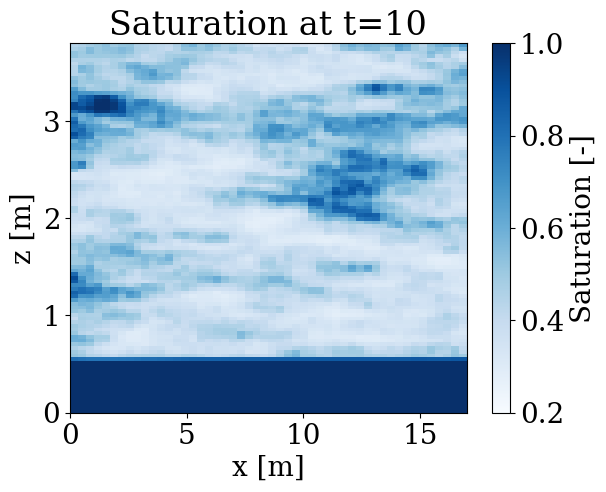

In [25]:
alpha_vG =100.0
correlated_random_field(alpha_vG,Sigma_input)
for time in time_array:
    #Saturation and pressure at time t = 0 hours
    plot_domain_corr_rnd(dir_name, "press", time,alpha_vG,Sigma_input); 
    plot_domain_corr_rnd(dir_name, "satur", time,alpha_vG,Sigma_input)

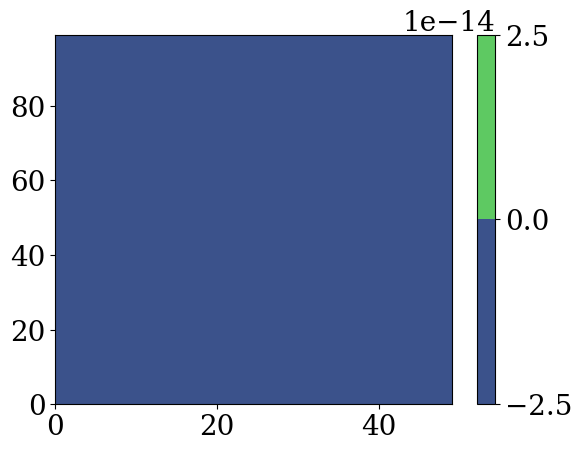

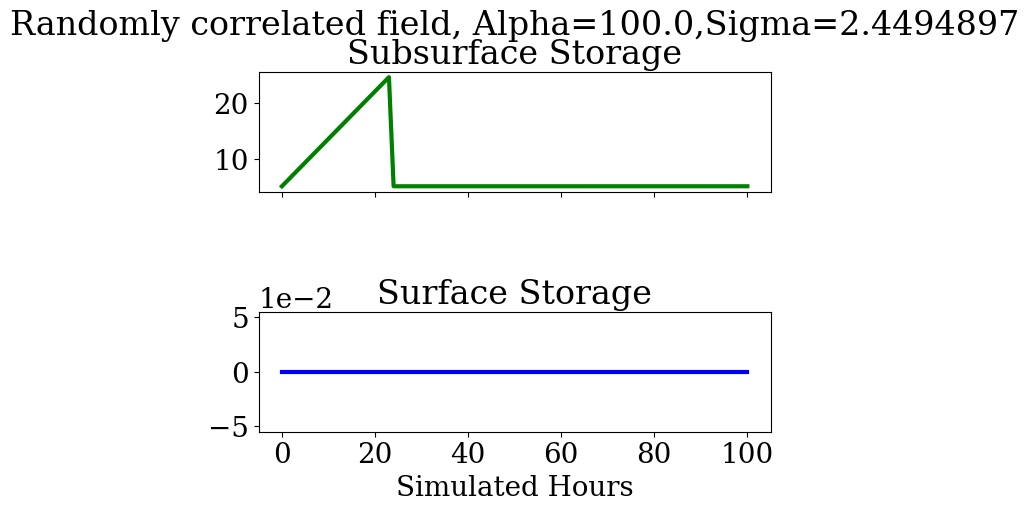

In [26]:
surface_subsurface_storage(alpha_vG,dir_name,run_name,Sigma_input)

/tmp/ipykernel_973658/698498494.py:3: RuntimeWarning: invalid value encountered in divide
  print((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100)
/tmp/ipykernel_973658/698498494.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100,color=blue)


[7.33196089 6.34111658 5.58647668 4.99180497 4.51192977 4.11620646
 3.78992077 3.50640046 3.26379412 3.05224132 2.8656992  2.70041351
 2.55380629 2.42205608 2.30398861 2.19581222 2.09773414 2.00758332
 1.92454864 1.84858117 1.77928483 1.71383908 1.6534648  1.59699737
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

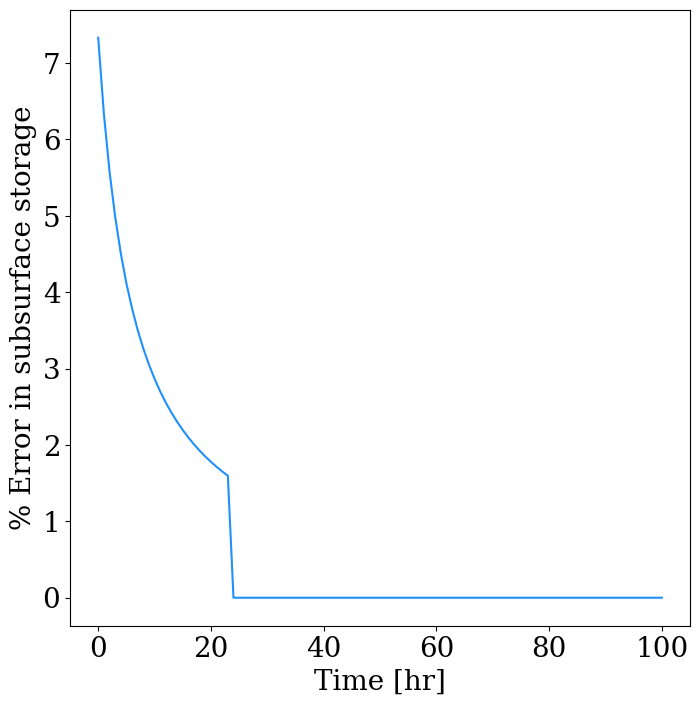

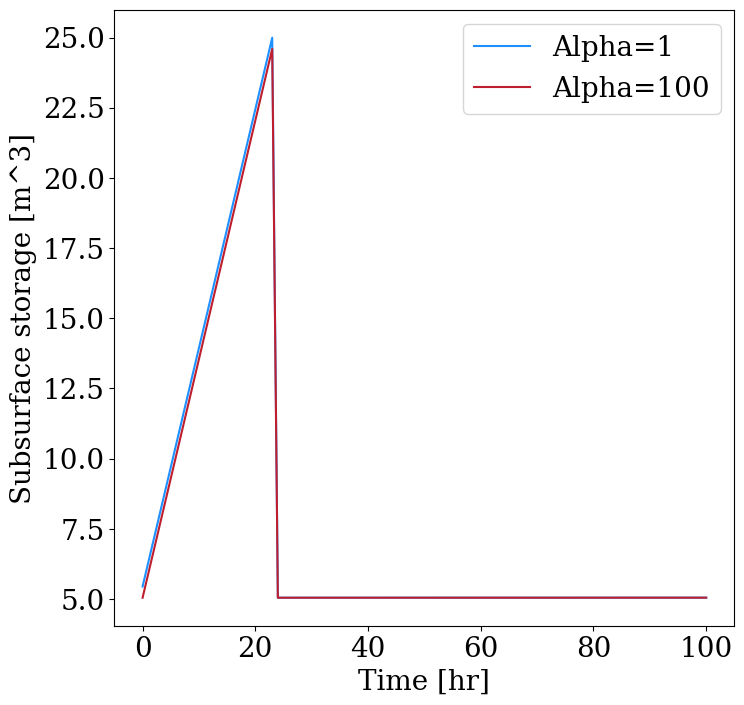

In [27]:
subsurface_storagealphavG100 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG100.0_sigma{Sigma_input}.npz');   subsurf_storage100   = subsurface_storagealphavG100['arr_0']
subsurface_storagealphavG1 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG1.0_sigma{Sigma_input}.npz');       subsurf_storage1   = subsurface_storagealphavG1['arr_0']
print((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100,color=blue)
plt.xlabel('Time [hr]')
plt.ylabel('% Error in subsurface storage')
plt.savefig(f'Rnd_corr_fields_Error__subsurface_storage_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot(subsurf_storage1[:-1],label='Alpha=1',color=blue)
plt.plot(subsurf_storage100[:-1],label='Alpha=100',color=red)
plt.xlabel('Time [hr]')
plt.ylabel('Subsurface storage [m^3]')
plt.legend()
plt.savefig(f'Rnd_corr_fields_subsurface_storage_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)

##### Difference in the contours for 5*sigma variance

(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


(100, 50) (100, 50) (100, 50)


/tmp/ipykernel_973658/3433107837.py:35: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,satur1_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_973658/3433107837.py:37: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(x_array,z_array,press1_data_array-press100_data_array,400, cmap='Blues',antialiased=False,edgecolor='face')
/tmp/ipykernel_973658/3433107837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


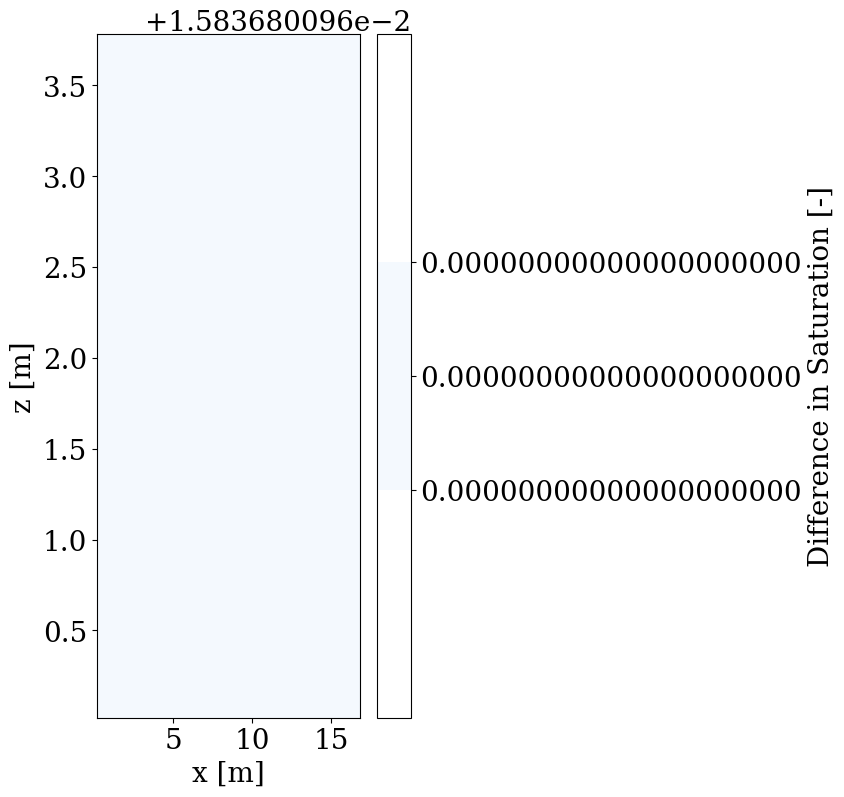

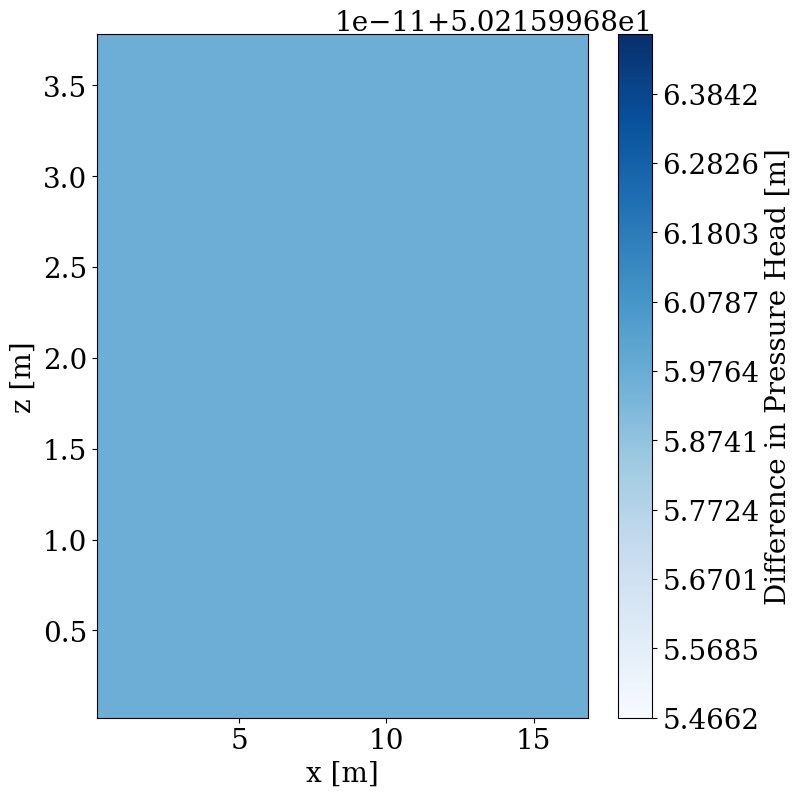

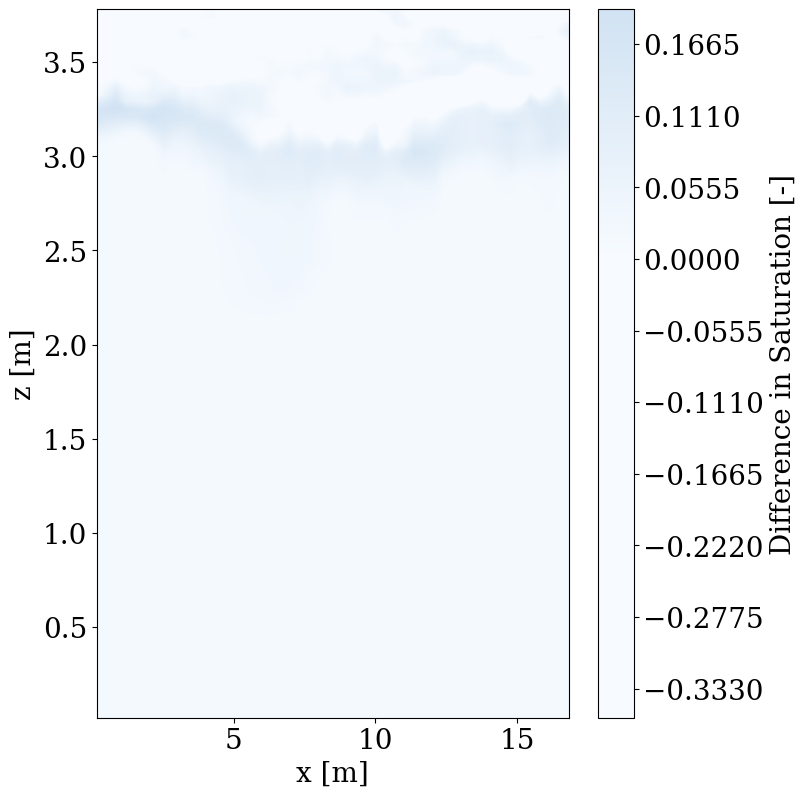

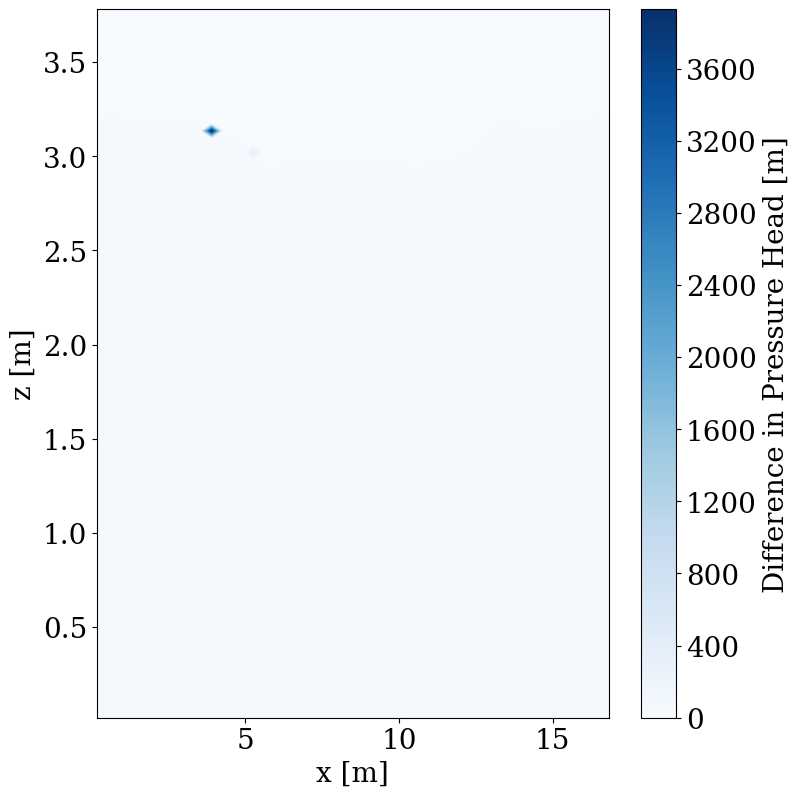

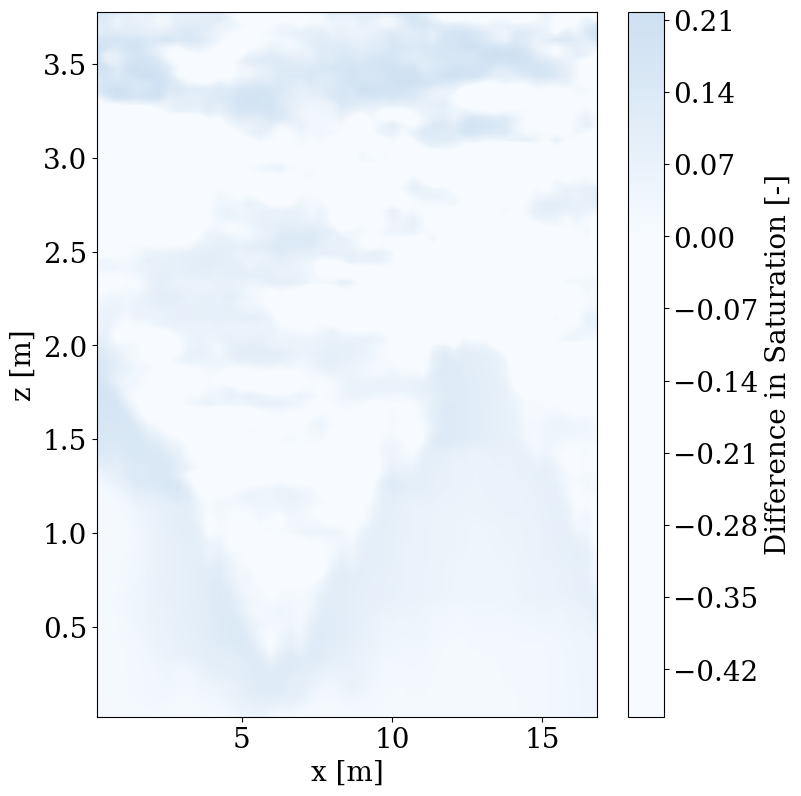

In [ ]:
for time in time_array:
    #Saturation and pressure difference at time t = 0 hours
    difference_plot(time)

In [2]:
###Difference in subsurface storage

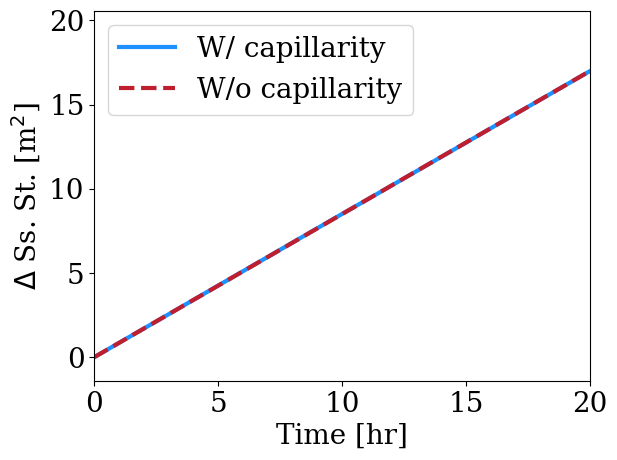

In [6]:
Sigma_input = 0.48989794

subsurface_storagealphavG100 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG100.0_sigma{Sigma_input}.npz');   subsurf_storage100   = subsurface_storagealphavG100['arr_0']
subsurface_storagealphavG1 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG1.0_sigma{Sigma_input}.npz');       subsurf_storage1   = subsurface_storagealphavG1['arr_0']

plt.figure()
plt.plot(subsurf_storage1[:-1]-subsurf_storage1[0],label='W/ capillarity',color=blue,linewidth=3)
plt.plot(subsurf_storage100[:-1]-subsurf_storage100[0],label='W/o capillarity',color=red,linewidth=3,linestyle='--')
plt.xlabel('Time [hr]')
plt.ylabel('$\Delta$ Ss. St. [m$^2$]')
plt.xlim([0,20])
plt.legend()
plt.savefig(f'Rnd_corr_fields_subsurface_storage_change_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)

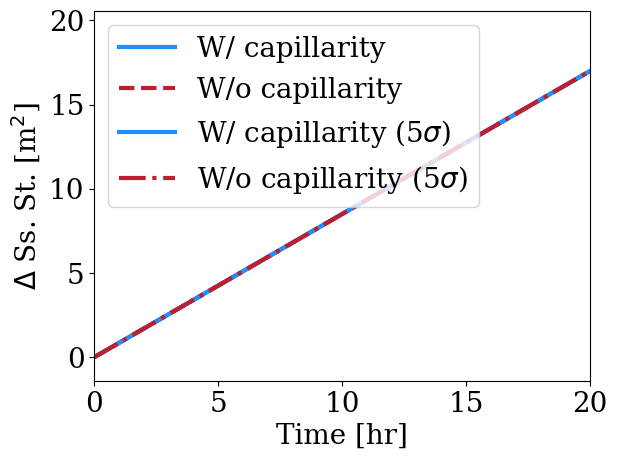

In [8]:
Sigma_input = 0.48989794

subsurface_storagealphavG100 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG100.0_sigma{Sigma_input}.npz');   subsurf_storage100   = subsurface_storagealphavG100['arr_0']
subsurface_storagealphavG1 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG1.0_sigma{Sigma_input}.npz');       subsurf_storage1   = subsurface_storagealphavG1['arr_0']

plt.figure()
plt.plot(subsurf_storage1[:-1]-subsurf_storage1[0],label='W/ capillarity',color=blue,linewidth=3)
plt.plot(subsurf_storage100[:-1]-subsurf_storage100[0],label='W/o capillarity',color=red,linewidth=3,linestyle='--')

subsurface_storagealphavG100 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG100.0_sigma{5*Sigma_input}.npz');   subsurf_storage100   = subsurface_storagealphavG100['arr_0']
subsurface_storagealphavG1 = np.load(f'Rnd_corr_fields_surface_subsurface_storage_alphavG1.0_sigma{5*Sigma_input}.npz');       subsurf_storage1   = subsurface_storagealphavG1['arr_0']

plt.plot(subsurf_storage1[:-1]-subsurf_storage1[0],label='W/ capillarity (5$\sigma$)',color=blue,linewidth=3)
plt.plot(subsurf_storage100[:-1]-subsurf_storage100[0],label='W/o capillarity (5$\sigma$)',color=red,linewidth=3,linestyle='-.')
plt.xlabel('Time [hr]')
plt.ylabel('$\Delta$ Ss. St. [m$^2$]')
plt.xlim([0,20])
plt.legend()
plt.savefig(f'Rnd_corr_fields_subsurface_storage_change_combined_sigma{Sigma_input}.pdf',bbox_inches='tight', dpi = 600)